<a href="https://colab.research.google.com/github/Tradergurl/final_project/blob/main/Kopia_notatnika_nltk_praca_nad_danymi_pk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ładuję potrzebne biblioteki

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re

pd.set_option('max_colwidth',400)


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

##
import nltk
from nltk import word_tokenize
from nltk.classify import SklearnClassifier
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import itertools

from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
#ładuję plik z danymi w formacie json
df=pd.read_json('/content/drive/MyDrive/nlp/News_Category_Dataset_v2.json',lines=True)

In [3]:
#usuwam kolumny z których nie będę korzystac przy zadaniu klasyfikacji
df = df.drop(columns=['link','date','authors'])

In [4]:
df.category.value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   short_description  200853 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB


In [6]:
#ograniczam liczbe klas poprzez łaczenie kilku kategorii w jedną i usunięcie niektórych

def change_category(new_category, category_to_change):
  df.category = df.category.map(lambda x: new_category if x == category_to_change else x)

In [7]:
change_category('WORLDPOST','THE WORLDPOST')
change_category('WORLDPOST','WORLD NEWS')
change_category('ARTS & CULTURE','CULTURE & ARTS')
change_category('ARTS & CULTURE','ARTS')
change_category('STYLE & BEAUTY','STYLE')
change_category('ENTERTAINMENT','COMEDY')
change_category('FOOD & DRINK','TASTE')
change_category('ENVIRONMENT','GREEN')
change_category('WELLNESS','HEALTHY LIVING')

In [8]:
categories_to_drop=['LATINO VOICES','GOOD NEWS','FIFTY','RELIGION','WEIRD NEWS','DIVORCE','WOMEN','WEDDINGS','BLACK VOICES','QUEER VOICES','PARENTS','PARENTING','EDUCATION','COLLEGE']

In [9]:
df = df[df.category.isin(categories_to_drop)==False]

In [10]:
df.category.value_counts()

POLITICS          32739
WELLNESS          24521
ENTERTAINMENT     21233
STYLE & BEAUTY    11903
TRAVEL             9887
WORLDPOST          8420
FOOD & DRINK       8322
BUSINESS           5937
SPORTS             4884
HOME & LIVING      4195
ENVIRONMENT        3945
ARTS & CULTURE     3878
IMPACT             3459
CRIME              3405
MEDIA              2815
SCIENCE            2178
TECH               2082
MONEY              1707
Name: category, dtype: int64

In [11]:
# pozostało 18 klas, 155510 rekordów
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155510 entries, 0 to 200852
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           155510 non-null  object
 1   headline           155510 non-null  object
 2   short_description  155510 non-null  object
dtypes: object(3)
memory usage: 4.7+ MB


In [12]:
df.reset_index(drop=True, inplace=True)

# Text preprocessing

In [13]:
#do rozwizania problemu będę korzystac z tekstu z polączenia headlina i short_description, 
df['text'] = df.headline + ' ' +df.short_description

In [14]:
# oczyszczam tekst
def cleaner(df, col_name):
    df[col_name] = df[col_name].str.lower()\
    .str.replace('\'s','')\
    .str.replace('\'re','')\
    .str.replace('\'m','')\
    .str.replace('\'ll','')\
    .str.replace('\'ve','')\
    .str.replace('\'d','') \
    .str.replace('\'t','')\
    .str.replace('[^a-z ]', '')\
    .str.replace('  ',' ')\
    .str.replace('the us','theus')\
    .str.replace('the u.s.','theus')\
    .str.replace('new york','newyork')
    return df

In [15]:
df=df.pipe(cleaner,'text')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
df['text'].head()

0                        there were mass shootings in texas last week but only on tv she left her husband he killed their children just another day in america
1                                                                 will smith joins diplo and nicky jam for the world cup official song of course it has a song
2                          hugh grant marries for the first time at age the actor and his longtime girlfriend anna eberstein tied the knot in a civil ceremony
3     jim carrey blasts castrato adam schiff and democrats in new artwork the actor gives dems an asskicking for not fighting hard enough against donald trump
4    julianna margulies uses donald trump poop bags to pick up after her dog the dietland actress said using the bags is a really cathartic therapeutic moment
Name: text, dtype: object

In [17]:
#usuwam z tekstu stopwords i tokenizuje go

list_stop_words = list(set(stopwords.words('english')))

all_text = df['text']

tokenized_text=[word_tokenize(line) for line in all_text]

text_nostop= [[word for word in text if word not in list_stop_words] for text in tokenized_text]

text_nostop[:2]


[['mass',
  'shootings',
  'texas',
  'last',
  'week',
  'tv',
  'left',
  'husband',
  'killed',
  'children',
  'another',
  'day',
  'america'],
 ['smith',
  'joins',
  'diplo',
  'nicky',
  'jam',
  'world',
  'cup',
  'official',
  'song',
  'course',
  'song']]

In [ ]:
#text_nostop_joint=[' '.join(element) for element in text_nostop]
#text_nostop_joint[:5]

# Wordcloud per category

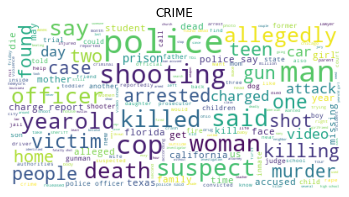

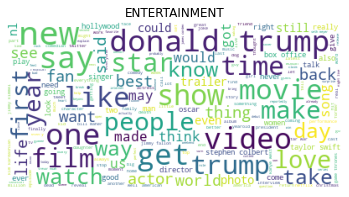

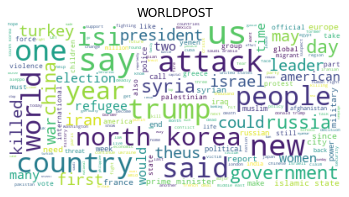

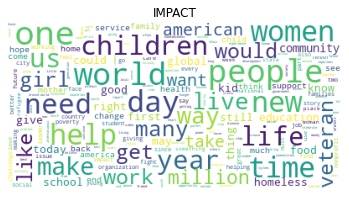

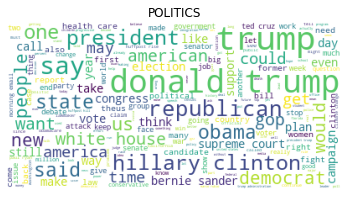

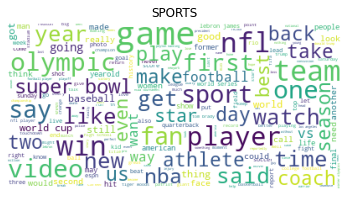

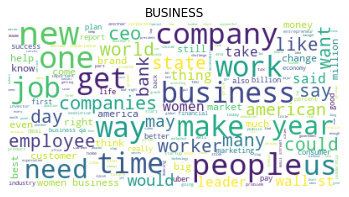

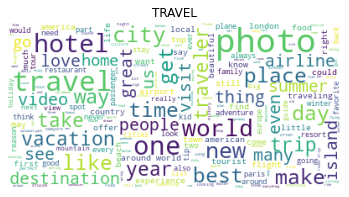

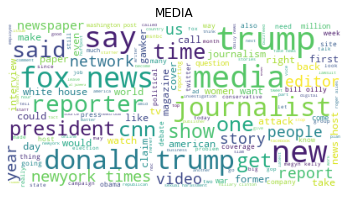

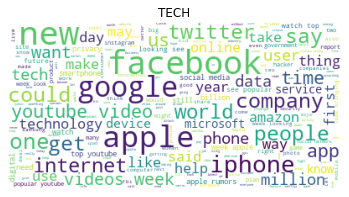

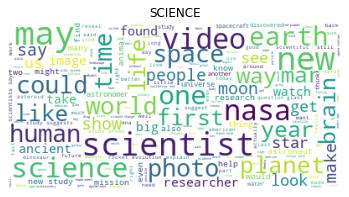

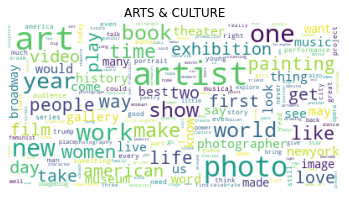

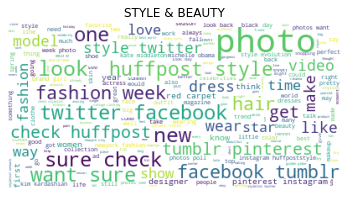

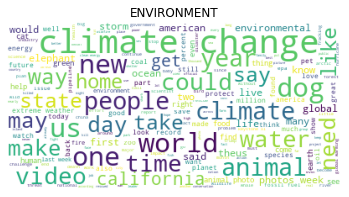

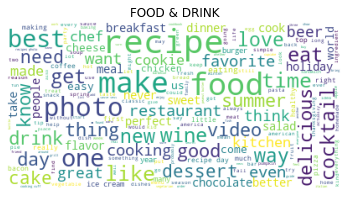

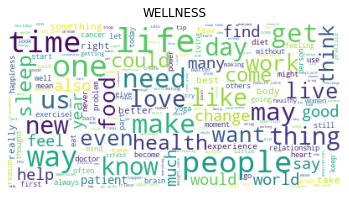

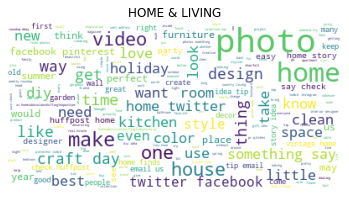

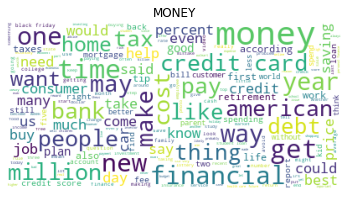

In [18]:
#stopwords = set(STOPWORDS)

# generuje wordcloud dla kazdej kategorii
for x in df.category.unique():
	wc = WordCloud(background_color="white", max_words=200, stopwords=list_stop_words,
                   max_font_size=40, random_state=42)
	wc.generate(df.text[(df.text.notnull()) & (df.category == x)].to_string())
	plt.imshow(wc)
	plt.title(x)
	plt.axis("off")
	plt.show()

# Stemming

In [19]:
from nltk.stem.porter import *

In [20]:
stemmer = PorterStemmer()

In [21]:
text_stemm= [[stemmer.stem(word) for word in text ] for text in text_nostop]


In [22]:
text_stemm[:2]

[['mass',
  'shoot',
  'texa',
  'last',
  'week',
  'tv',
  'left',
  'husband',
  'kill',
  'children',
  'anoth',
  'day',
  'america'],
 ['smith',
  'join',
  'diplo',
  'nicki',
  'jam',
  'world',
  'cup',
  'offici',
  'song',
  'cours',
  'song']]

In [23]:
text_stemm_joint=[' '.join(line) for line in text_stemm ]
df['stem']= pd.DataFrame(text_stemm_joint)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155510 entries, 0 to 155509
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           155510 non-null  object
 1   headline           155510 non-null  object
 2   short_description  155510 non-null  object
 3   text               155510 non-null  object
 4   stem               155510 non-null  object
dtypes: object(5)
memory usage: 5.9+ MB


# Lemmatization

In [25]:
lemmatizer = WordNetLemmatizer()

In [26]:
text_lemma=[[lemmatizer.lemmatize(word) for word in text] for text in text_nostop]

In [27]:
text_lemma[:2]

[['mass',
  'shooting',
  'texas',
  'last',
  'week',
  'tv',
  'left',
  'husband',
  'killed',
  'child',
  'another',
  'day',
  'america'],
 ['smith',
  'join',
  'diplo',
  'nicky',
  'jam',
  'world',
  'cup',
  'official',
  'song',
  'course',
  'song']]

In [28]:
text_lemma_joint=[' '.join(line) for line in text_lemma]
df['lemma']=pd.DataFrame(text_lemma_joint)

In [29]:
df.drop(columns=['headline','short_description'], inplace=True)

In [30]:
#dzielę zbiór danych na dane treningowe i testowe
train,test= train_test_split(df, test_size = 0.3, stratify=df['category'], random_state=48)

In [31]:
train_data= pd.DataFrame(train)
test_data= pd.DataFrame(test)

In [32]:
train_data.head()

category  ...                                                                                                                                                 lemma
118151  STYLE & BEAUTY  ...  miley cyrus v kat graham wore versace better photo poll kat want sure check huffpost style twitter facebook tumblr pinterest instagram huffpoststyle
13467         POLITICS  ...                  struggling gun industry look congress make silencer next big thing amid trump slump firearm industry seek laxer rule suppressor sale
81264     FOOD & DRINK  ...      christmas holiday cracker beach goose fully cooked take bird oven let rest minute warm place kitchen sure reserve juice oven tray use rich sauce
68053        WORLDPOST  ...     merkel rule greek debt writeoff open relief berlin ap chancellor angela merkel sunday suggested germany would show flexibility negotiating greece
113769   HOME & LIVING  ...        silver lake california house come turret photo something say check huffpost home twitter facebook pinterest tumblr instagram buying castle may

[5 rows x 4 columns]

# Vectorization

In [33]:
bow =CountVectorizer(min_df=5, max_df=0.3, ngram_range=(1,2))

In [34]:
#wektoryzyje slowa po stemmingu
X_train_stem = bow.fit_transform(train_data['stem'])
X_test_stem = bow.transform(test_data['stem'])

#wektoryzuje slowa po lemmatyzacji
X_train_lemma = bow.fit_transform(train_data['lemma'])
X_test_lemma = bow.transform(test_data['lemma'])

# Vectorization TF-IDF

In [35]:
tfidf=TfidfVectorizer(min_df=5, max_df=0.3,ngram_range=(1,2), sublinear_tf=True)

In [36]:
#Wektoryzuje slowa po stemmingu
X_train_tfidf_stem = tfidf.fit_transform(train_data['stem'])
X_test_tfidf_stem = tfidf.transform(test_data['stem'])

#wektoryzuje slowa po lemmatyzacji
X_train_tfidf_lemma = tfidf.fit_transform(train_data['lemma'])
X_test_tfidf_lemma = tfidf.transform(test_data['lemma'])

In [37]:
y_train = train_data.category
y_test= test_data.category

# Classification models

In [38]:
from sklearn.svm import LinearSVC
nb_model=MultinomialNB()
lr= LogisticRegression()
sgdc_model= SGDClassifier()
svm= LinearSVC()
rfc=RandomForestClassifier()

# Naive Bayes

In [ ]:
#nb_model= MultinomialNB()

## Bag of words ngram (1,2) stemmed data 

In [39]:
nb_model.fit(X_train_stem,y_train)

MultinomialNB()

In [40]:
y_pred_train=nb_model.predict(X_train_stem)
y_pred_test=nb_model.predict(X_test_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

nb_bow_stem_train_acc = accuracy_score(y_train, y_pred_train)
nb_bow_stem_test_acc = accuracy_score(y_test, y_pred_test)
nb_bow_stem_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.8098147110429279
ACC test set: 0.7310355175444238
Mislabeled no: 12548
                precision    recall  f1-score   support

ARTS & CULTURE       0.70      0.39      0.50      1163
      BUSINESS       0.50      0.51      0.51      1781
         CRIME       0.64      0.67      0.66      1022
 ENTERTAINMENT       0.74      0.78      0.76      6370
   ENVIRONMENT       0.58      0.49      0.53      1184
  FOOD & DRINK       0.77      0.81      0.79      2497
 HOME & LIVING       0.84      0.69      0.76      1258
        IMPACT       0.54      0.30      0.39      1038
         MEDIA       0.73      0.31      0.43       844
         MONEY       0.63      0.22      0.32       512
      POLITICS       0.79      0.83      0.81      9822
       SCIENCE       0.86      0.33      0.48       653
        SPORTS       0.81      0.67      0.73      1465
STYLE & BEAUTY       0.82      0.80      0.81      3571
          TECH       0.71      0.22      0.33       625
        TRAVEL 

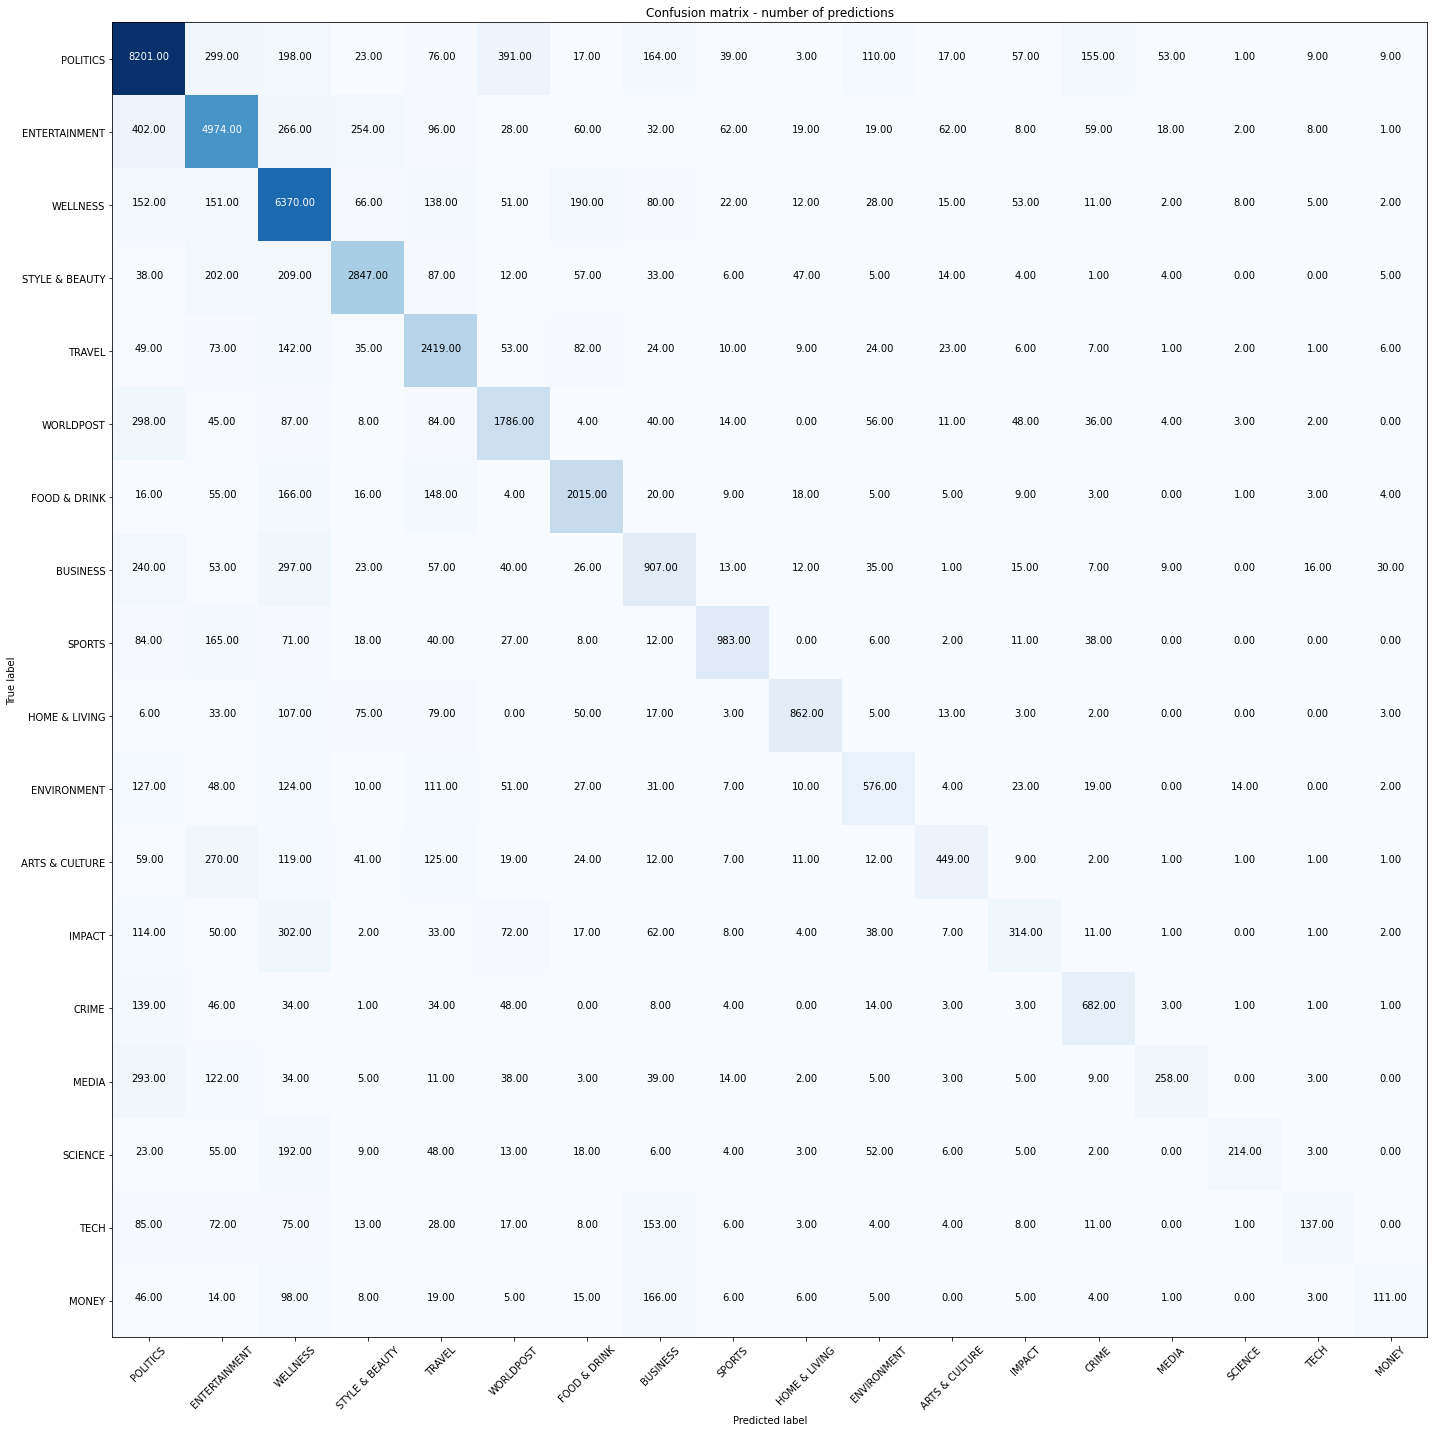

In [41]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Bag of words ngram (1,2) lemmatized data 

In [42]:
nb_model.fit(X_train_lemma,y_train)

MultinomialNB()

In [43]:
y_pred_train=nb_model.predict(X_train_lemma)
y_pred_test=nb_model.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

nb_bow_lemma_train_acc = accuracy_score(y_train, y_pred_train)
nb_bow_lemma_test_acc = accuracy_score(y_test, y_pred_test)
nb_bow_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.8155470020301864
ACC test set: 0.7351938782071893
Mislabeled no: 12354
                precision    recall  f1-score   support

ARTS & CULTURE       0.69      0.40      0.50      1163
      BUSINESS       0.50      0.51      0.51      1781
         CRIME       0.65      0.69      0.67      1022
 ENTERTAINMENT       0.74      0.79      0.76      6370
   ENVIRONMENT       0.58      0.50      0.54      1184
  FOOD & DRINK       0.77      0.81      0.79      2497
 HOME & LIVING       0.85      0.70      0.77      1258
        IMPACT       0.51      0.32      0.39      1038
         MEDIA       0.71      0.32      0.44       844
         MONEY       0.65      0.24      0.35       512
      POLITICS       0.80      0.83      0.81      9822
       SCIENCE       0.84      0.35      0.50       653
        SPORTS       0.82      0.69      0.75      1465
STYLE & BEAUTY       0.83      0.80      0.81      3571
          TECH       0.68      0.23      0.35       625
        TRAVEL 

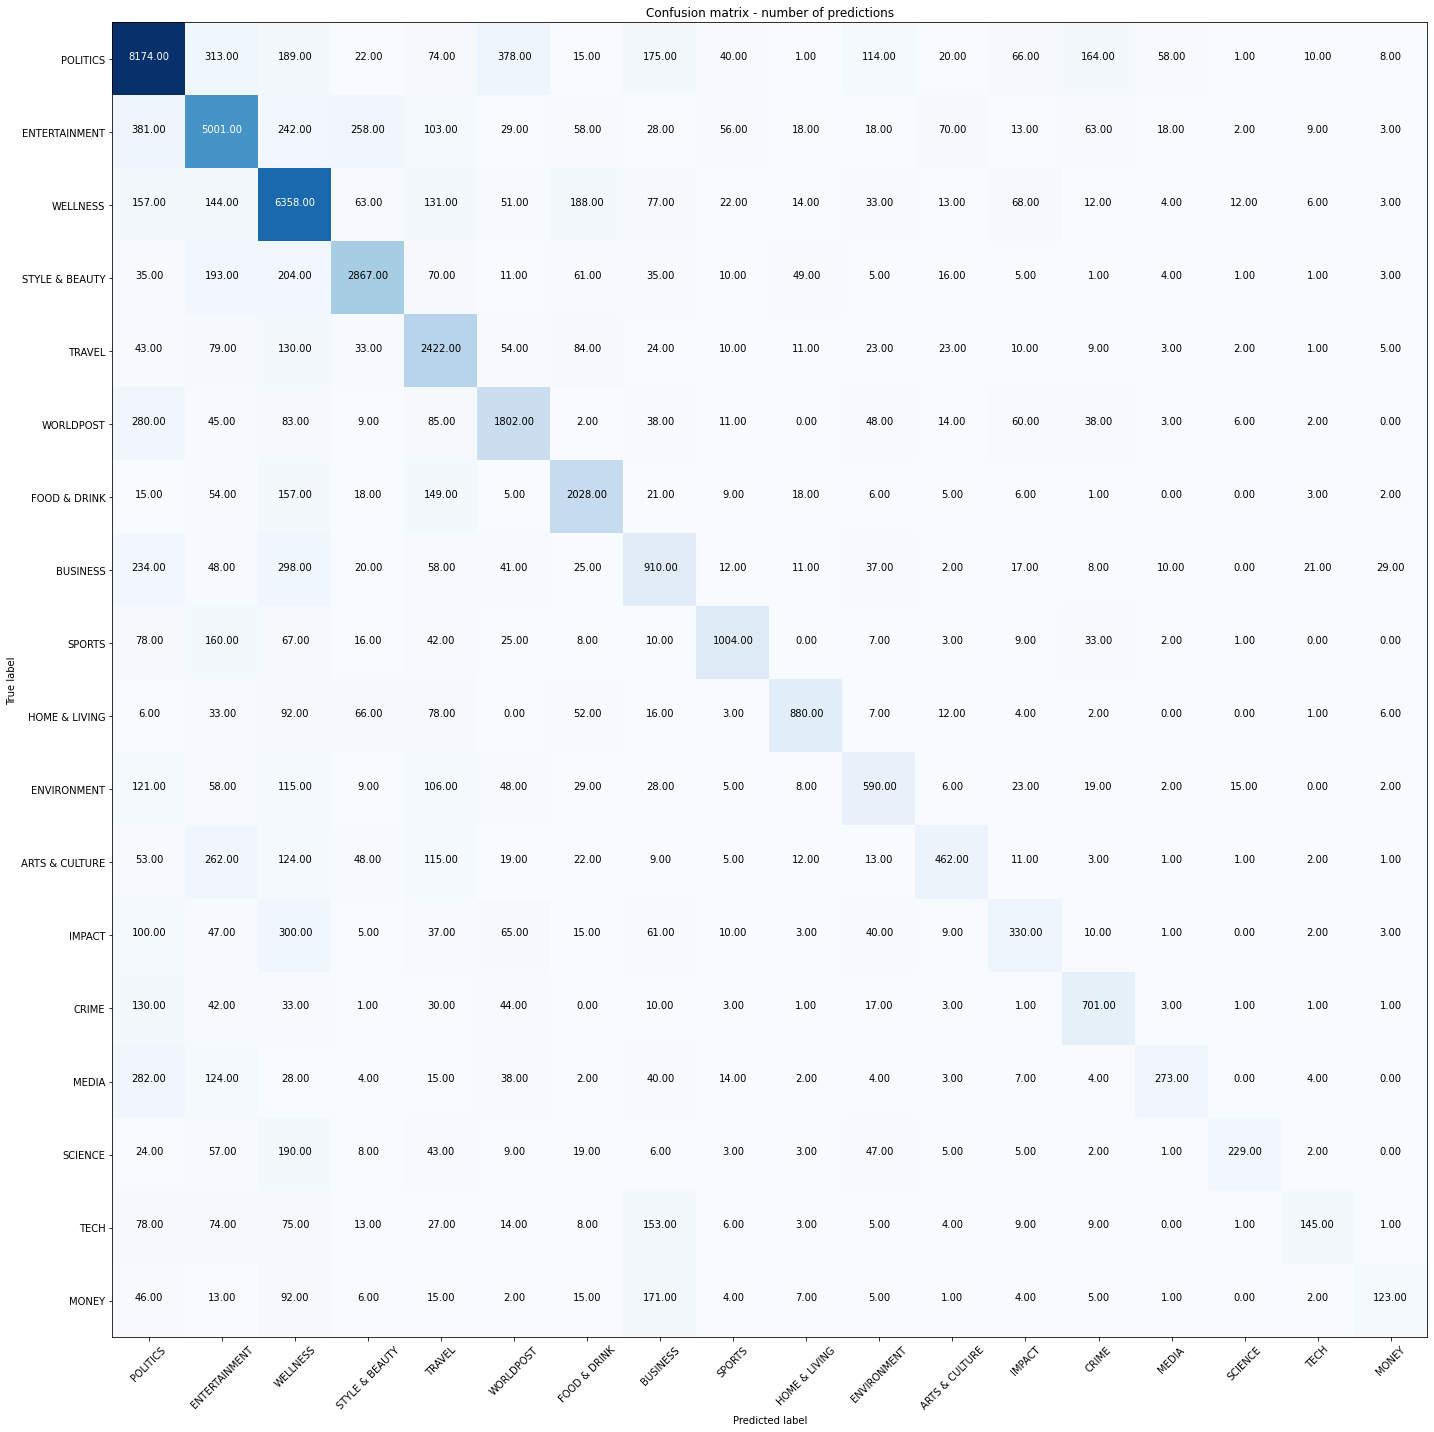

In [44]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF stemmed data

In [45]:
nb_model.fit(X_train_tfidf_stem,y_train)

MultinomialNB()

In [46]:
y_pred_train=nb_model.predict(X_train_tfidf_stem)
y_pred_test=nb_model.predict(X_test_tfidf_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

nb_tfidf_stem_train_acc = accuracy_score(y_train, y_pred_train)
nb_tfidf_stem_test_acc = accuracy_score(y_test, y_pred_test)
nb_tfidf_stem_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.6706137409629146
ACC test set: 0.6266049343021884
Mislabeled no: 17420
                precision    recall  f1-score   support

ARTS & CULTURE       0.97      0.05      0.09      1163
      BUSINESS       0.77      0.09      0.16      1781
         CRIME       0.93      0.13      0.22      1022
 ENTERTAINMENT       0.64      0.80      0.71      6370
   ENVIRONMENT       0.92      0.07      0.12      1184
  FOOD & DRINK       0.87      0.61      0.72      2497
 HOME & LIVING       0.97      0.29      0.45      1258
        IMPACT       0.50      0.00      0.00      1038
         MEDIA       1.00      0.01      0.02       844
         MONEY       1.00      0.00      0.00       512
      POLITICS       0.57      0.95      0.71      9822
       SCIENCE       1.00      0.03      0.05       653
        SPORTS       0.92      0.24      0.38      1465
STYLE & BEAUTY       0.85      0.70      0.77      3571
          TECH       1.00      0.04      0.08       625
        TRAVEL 

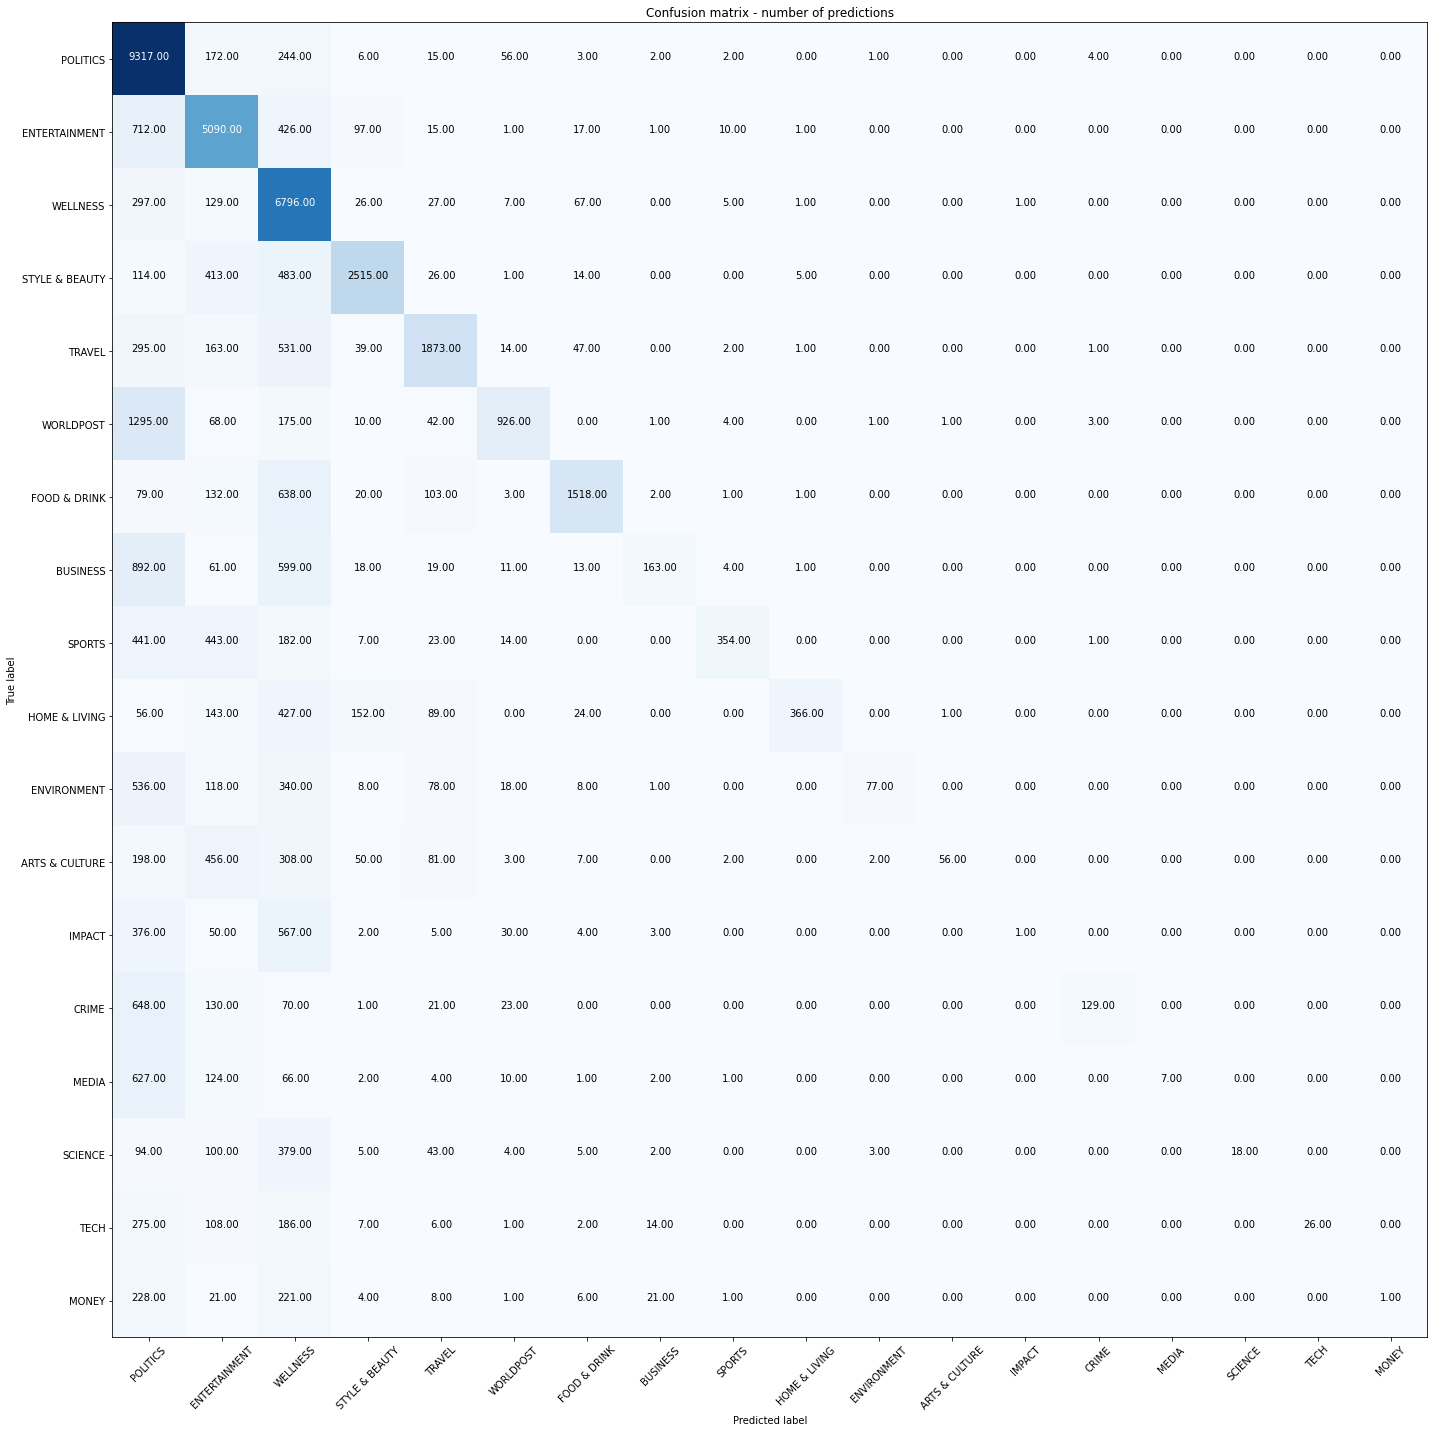

In [47]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF lemmatized data

In [48]:
nb_model.fit(X_train_tfidf_lemma,y_train)

MultinomialNB()

In [49]:
y_pred_train=nb_model.predict(X_train_tfidf_lemma)
y_pred_test=nb_model.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

nb_tfidf_lemma_train_acc = accuracy_score(y_train, y_pred_train)
nb_tfidf_lemma_test_acc = accuracy_score(y_test, y_pred_test)
nb_tfidf_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.678174118338738
ACC test set: 0.6327567359012282
Mislabeled no: 17133
                precision    recall  f1-score   support

ARTS & CULTURE       0.97      0.05      0.09      1163
      BUSINESS       0.75      0.10      0.18      1781
         CRIME       0.90      0.14      0.24      1022
 ENTERTAINMENT       0.65      0.81      0.72      6370
   ENVIRONMENT       0.89      0.08      0.14      1184
  FOOD & DRINK       0.87      0.62      0.72      2497
 HOME & LIVING       0.97      0.31      0.47      1258
        IMPACT       0.67      0.00      0.00      1038
         MEDIA       0.82      0.01      0.02       844
         MONEY       0.50      0.00      0.00       512
      POLITICS       0.57      0.95      0.71      9822
       SCIENCE       1.00      0.04      0.07       653
        SPORTS       0.92      0.27      0.42      1465
STYLE & BEAUTY       0.85      0.71      0.77      3571
          TECH       1.00      0.04      0.08       625
        TRAVEL  

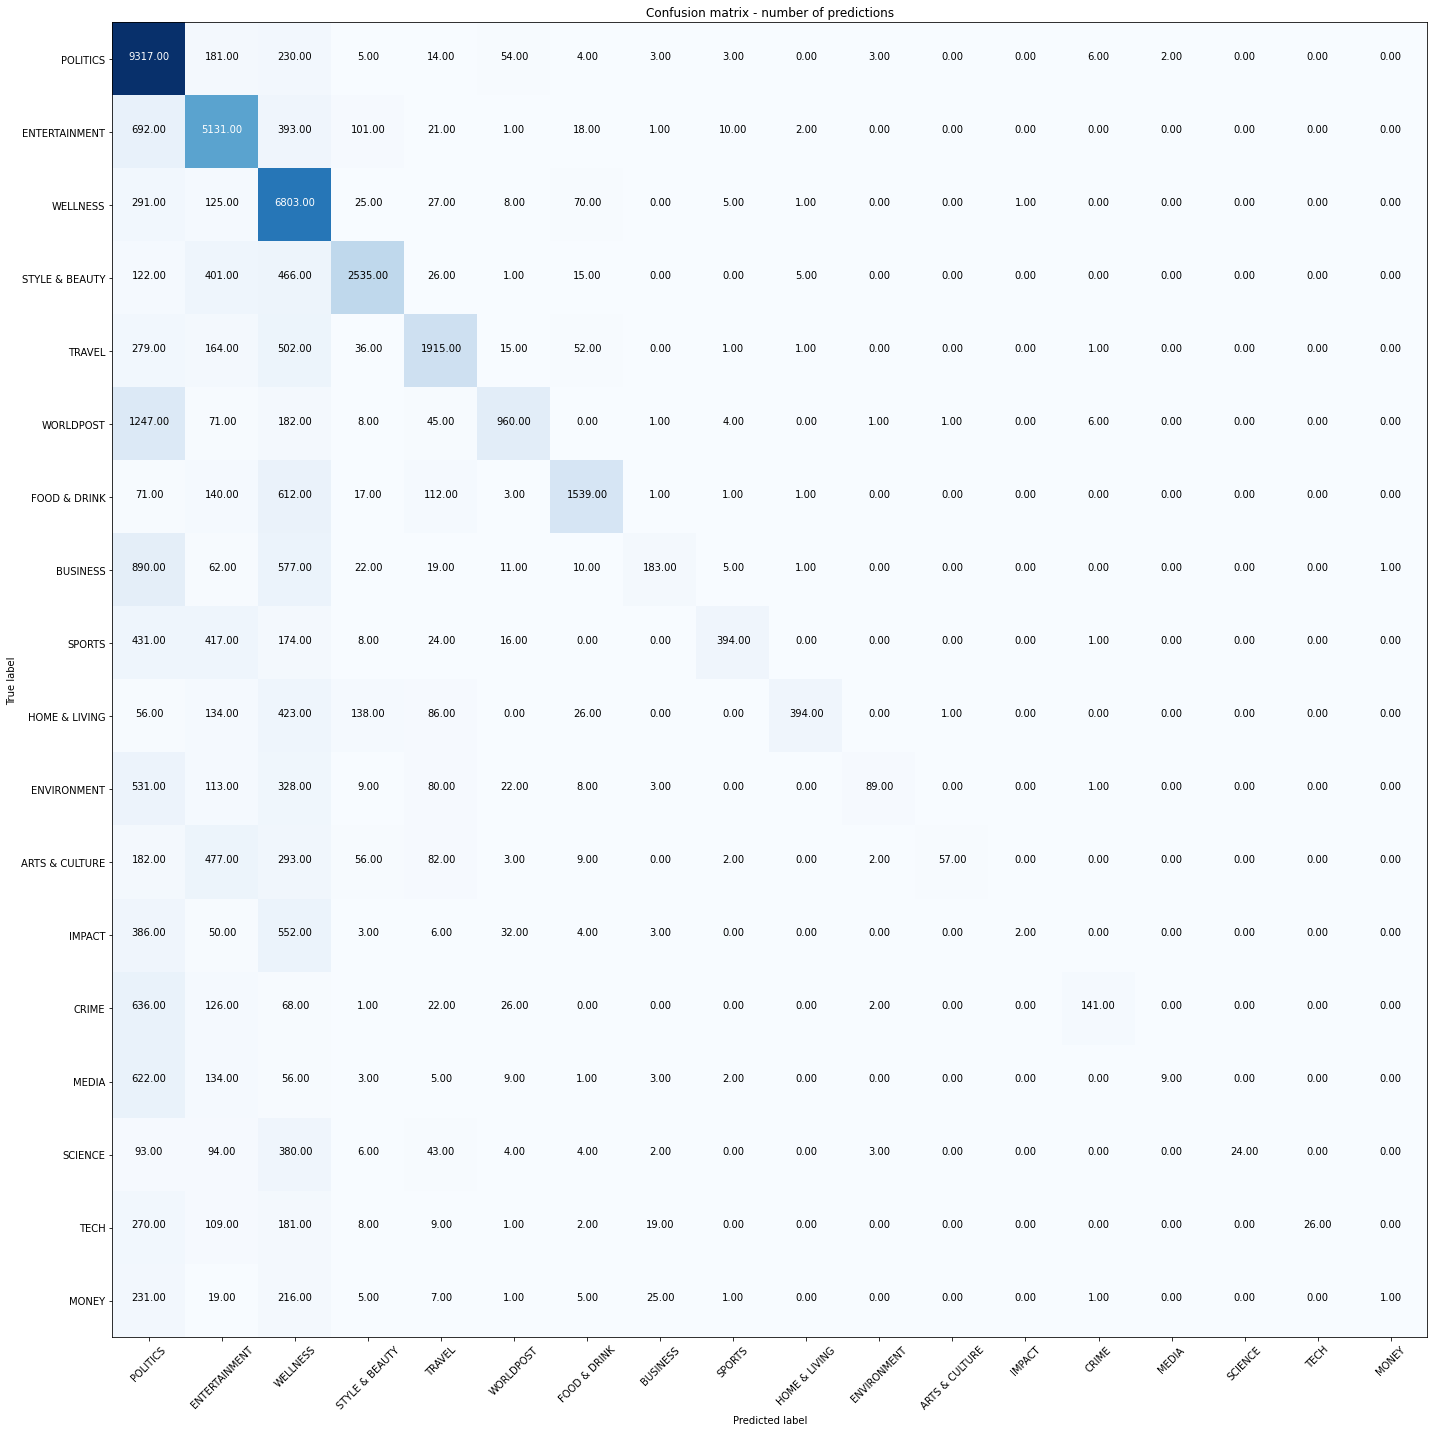

In [50]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Logistic Regression

In [51]:
lr= LogisticRegression(max_iter=10000)

## Bag of words ngram (1,2) stemmed data

In [52]:
lr.fit(X_train_stem,y_train)

LogisticRegression(max_iter=10000)

In [53]:
y_pred_train=lr.predict(X_train_stem)
y_pred_test=lr.predict(X_test_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

log_reg_bow_stemm_acc_train = accuracy_score(y_train, y_pred_train)
log_reg_bow_stemm_acc_test = accuracy_score(y_test, y_pred_test)
log_reg_bow_stem_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9732584950898886
ACC test set: 0.7351081388120807
Mislabeled no: 12358
                precision    recall  f1-score   support

ARTS & CULTURE       0.60      0.50      0.55      1163
      BUSINESS       0.53      0.48      0.50      1781
         CRIME       0.69      0.62      0.65      1022
 ENTERTAINMENT       0.72      0.81      0.76      6370
   ENVIRONMENT       0.56      0.48      0.52      1184
  FOOD & DRINK       0.79      0.78      0.79      2497
 HOME & LIVING       0.79      0.73      0.76      1258
        IMPACT       0.45      0.33      0.38      1038
         MEDIA       0.62      0.43      0.51       844
         MONEY       0.55      0.39      0.46       512
      POLITICS       0.77      0.85      0.81      9822
       SCIENCE       0.67      0.46      0.55       653
        SPORTS       0.78      0.70      0.74      1465
STYLE & BEAUTY       0.84      0.80      0.82      3571
          TECH       0.56      0.41      0.47       625
        TRAVEL 

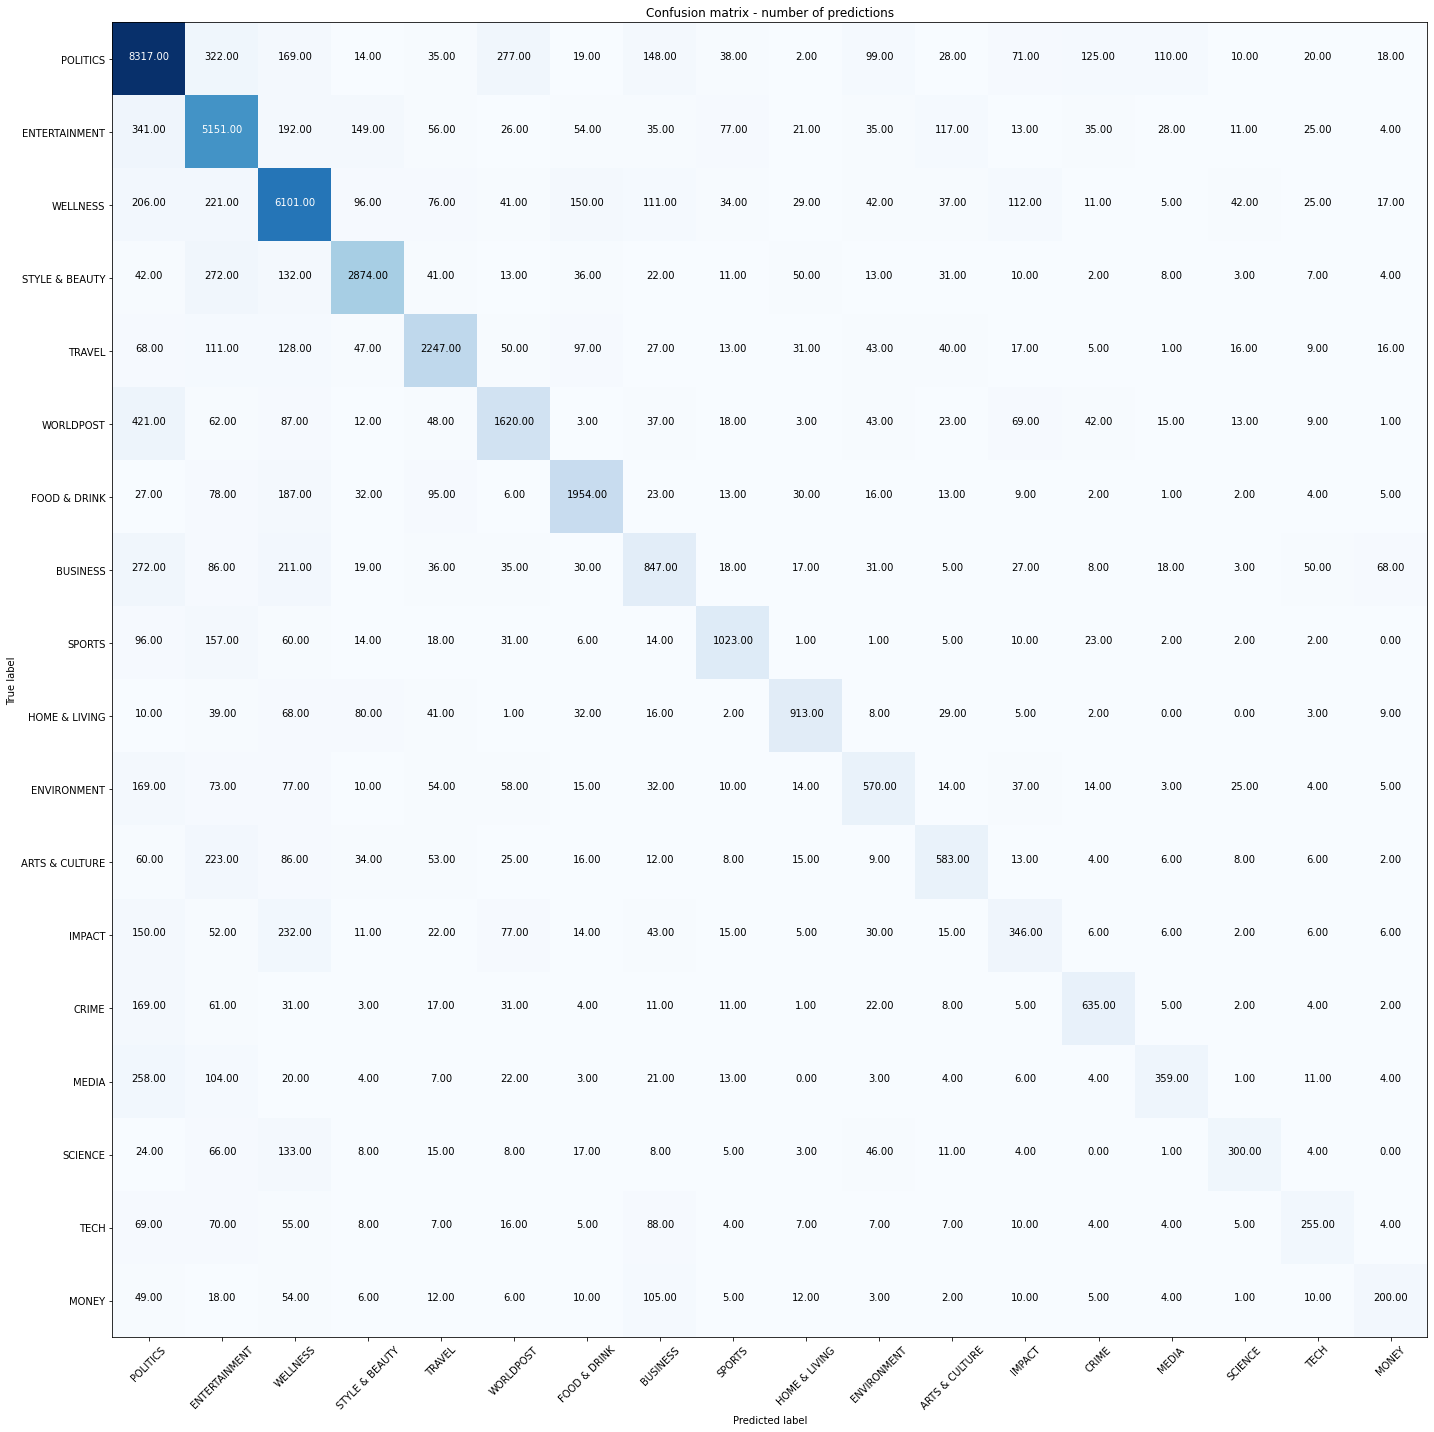

In [54]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Bag of words ngram (1,2) lemmatized data

In [55]:
lr.fit(X_train_lemma,y_train)

LogisticRegression(max_iter=10000)

In [56]:
y_pred_train=lr.predict(X_train_lemma)
y_pred_test=lr.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

log_reg_bow_lemma_acc_train = accuracy_score(y_train, y_pred_train)
log_reg_bow_lemma_acc_test = accuracy_score(y_test, y_pred_test)
log_reg_bow_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9761246405835178
ACC test set: 0.7360084024607206
Mislabeled no: 12316
                precision    recall  f1-score   support

ARTS & CULTURE       0.62      0.50      0.55      1163
      BUSINESS       0.52      0.47      0.49      1781
         CRIME       0.70      0.62      0.66      1022
 ENTERTAINMENT       0.72      0.81      0.76      6370
   ENVIRONMENT       0.56      0.47      0.51      1184
  FOOD & DRINK       0.79      0.78      0.79      2497
 HOME & LIVING       0.80      0.73      0.77      1258
        IMPACT       0.45      0.33      0.38      1038
         MEDIA       0.59      0.42      0.49       844
         MONEY       0.57      0.42      0.48       512
      POLITICS       0.77      0.84      0.81      9822
       SCIENCE       0.68      0.48      0.56       653
        SPORTS       0.79      0.70      0.74      1465
STYLE & BEAUTY       0.85      0.81      0.83      3571
          TECH       0.57      0.40      0.47       625
        TRAVEL 

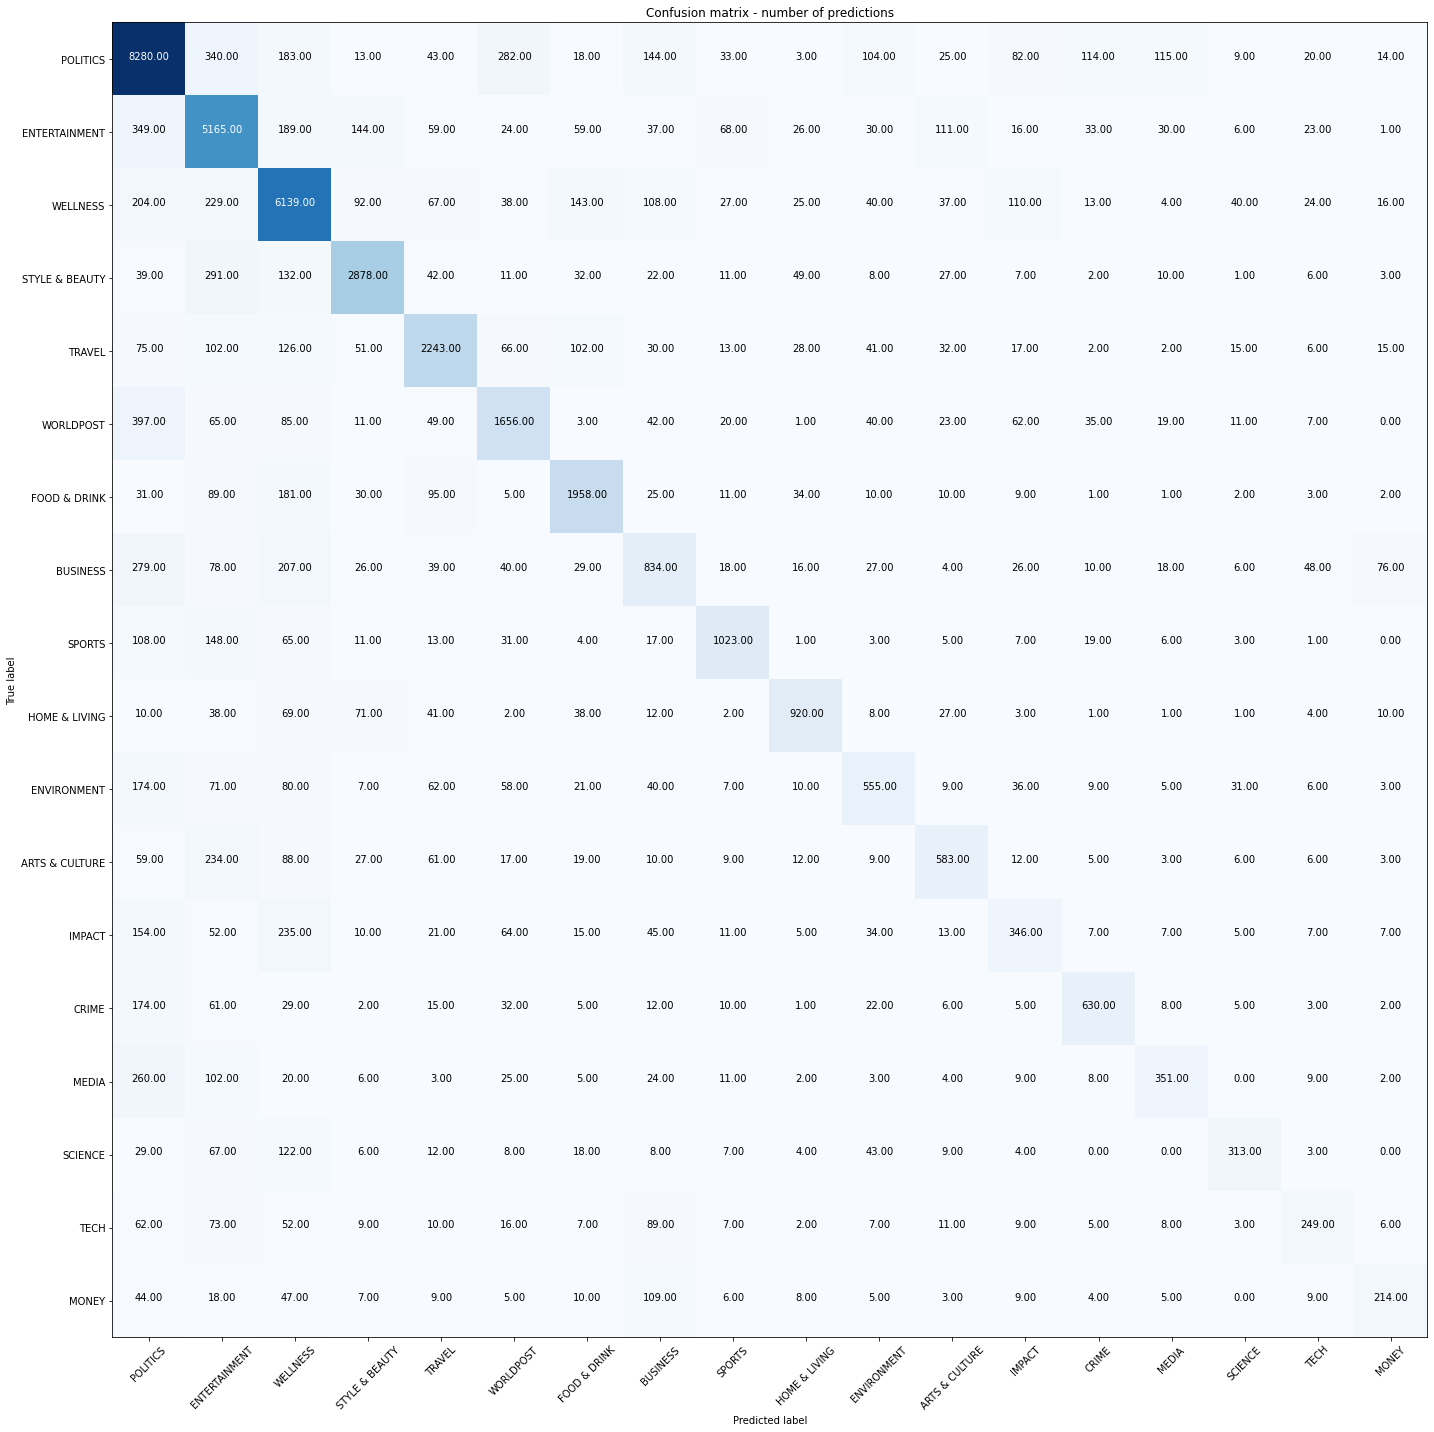

In [57]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF Stemmed data

In [58]:
lr.fit(X_train_tfidf_stem,y_train)

LogisticRegression(max_iter=10000)

In [59]:
y_pred_train=lr.predict(X_train_tfidf_stem)
y_pred_test=lr.predict(X_test_tfidf_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

log_reg_tfidf_stemm_acc_train = accuracy_score(y_train, y_pred_train)
log_reg_tfidf_stemm_acc_test = accuracy_score(y_test, y_pred_test)
log_reg_tfidf_stem_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.8231533112248178
ACC test set: 0.7428889889181832
Mislabeled no: 11995
                precision    recall  f1-score   support

ARTS & CULTURE       0.71      0.43      0.53      1163
      BUSINESS       0.59      0.45      0.51      1781
         CRIME       0.73      0.57      0.64      1022
 ENTERTAINMENT       0.72      0.83      0.77      6370
   ENVIRONMENT       0.61      0.46      0.53      1184
  FOOD & DRINK       0.82      0.78      0.80      2497
 HOME & LIVING       0.83      0.70      0.76      1258
        IMPACT       0.57      0.28      0.38      1038
         MEDIA       0.71      0.36      0.48       844
         MONEY       0.67      0.33      0.44       512
      POLITICS       0.76      0.88      0.81      9822
       SCIENCE       0.84      0.39      0.53       653
        SPORTS       0.82      0.67      0.74      1465
STYLE & BEAUTY       0.84      0.81      0.82      3571
          TECH       0.64      0.36      0.46       625
        TRAVEL 

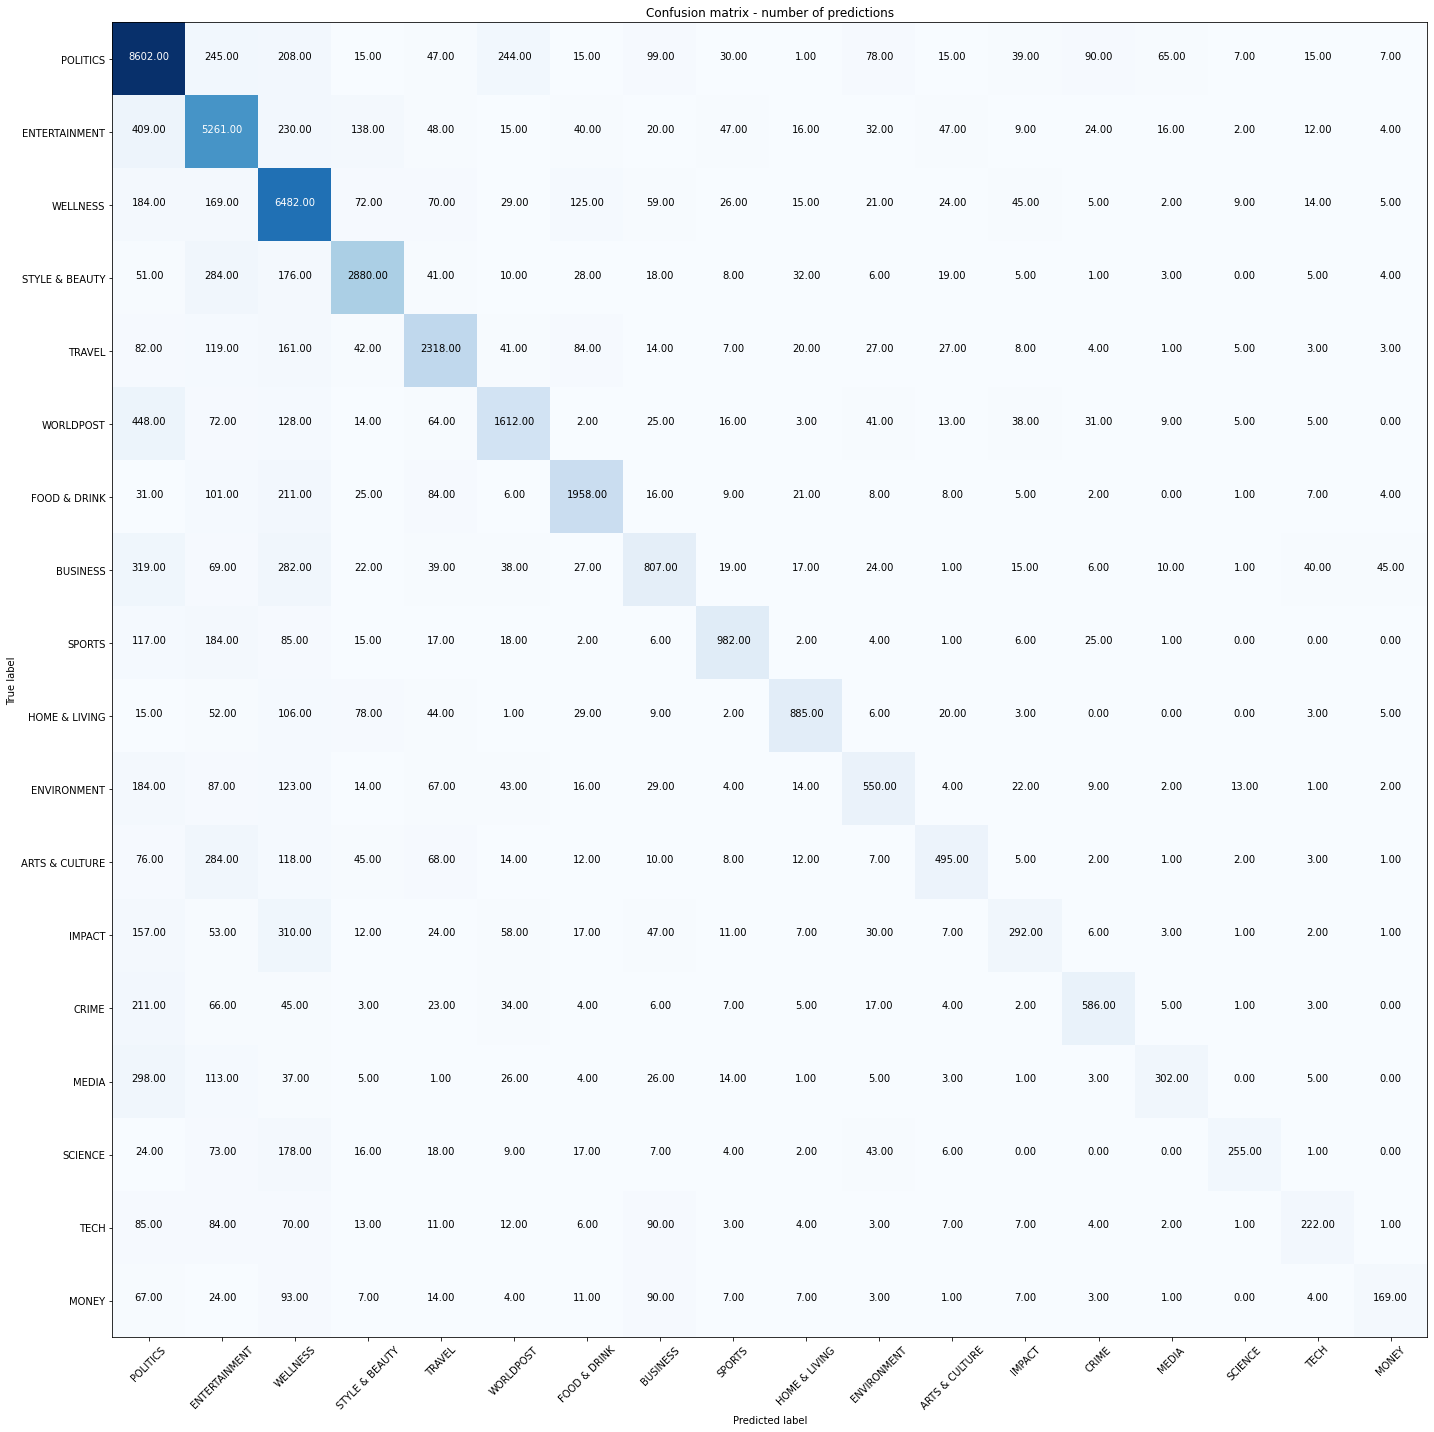

In [60]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF Lemmatized data

In [61]:
lr.fit(X_train_tfidf_lemma,y_train)

LogisticRegression(max_iter=10000)

In [62]:
y_pred_train=lr.predict(X_train_tfidf_lemma)
y_pred_test=lr.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

log_reg_tfidf_lemma_acc_train = accuracy_score(y_train, y_pred_train)
log_reg_tfidf_lemma_acc_test = accuracy_score(y_test, y_pred_test)
log_reg_tfidf_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.8271953112799361
ACC test set: 0.7442822540886974
Mislabeled no: 11930
                precision    recall  f1-score   support

ARTS & CULTURE       0.71      0.43      0.54      1163
      BUSINESS       0.58      0.45      0.51      1781
         CRIME       0.75      0.58      0.65      1022
 ENTERTAINMENT       0.71      0.83      0.77      6370
   ENVIRONMENT       0.62      0.46      0.52      1184
  FOOD & DRINK       0.82      0.78      0.80      2497
 HOME & LIVING       0.84      0.70      0.76      1258
        IMPACT       0.58      0.28      0.37      1038
         MEDIA       0.69      0.36      0.48       844
         MONEY       0.69      0.32      0.44       512
      POLITICS       0.76      0.88      0.81      9822
       SCIENCE       0.85      0.39      0.53       653
        SPORTS       0.82      0.67      0.74      1465
STYLE & BEAUTY       0.85      0.81      0.83      3571
          TECH       0.65      0.34      0.45       625
        TRAVEL 

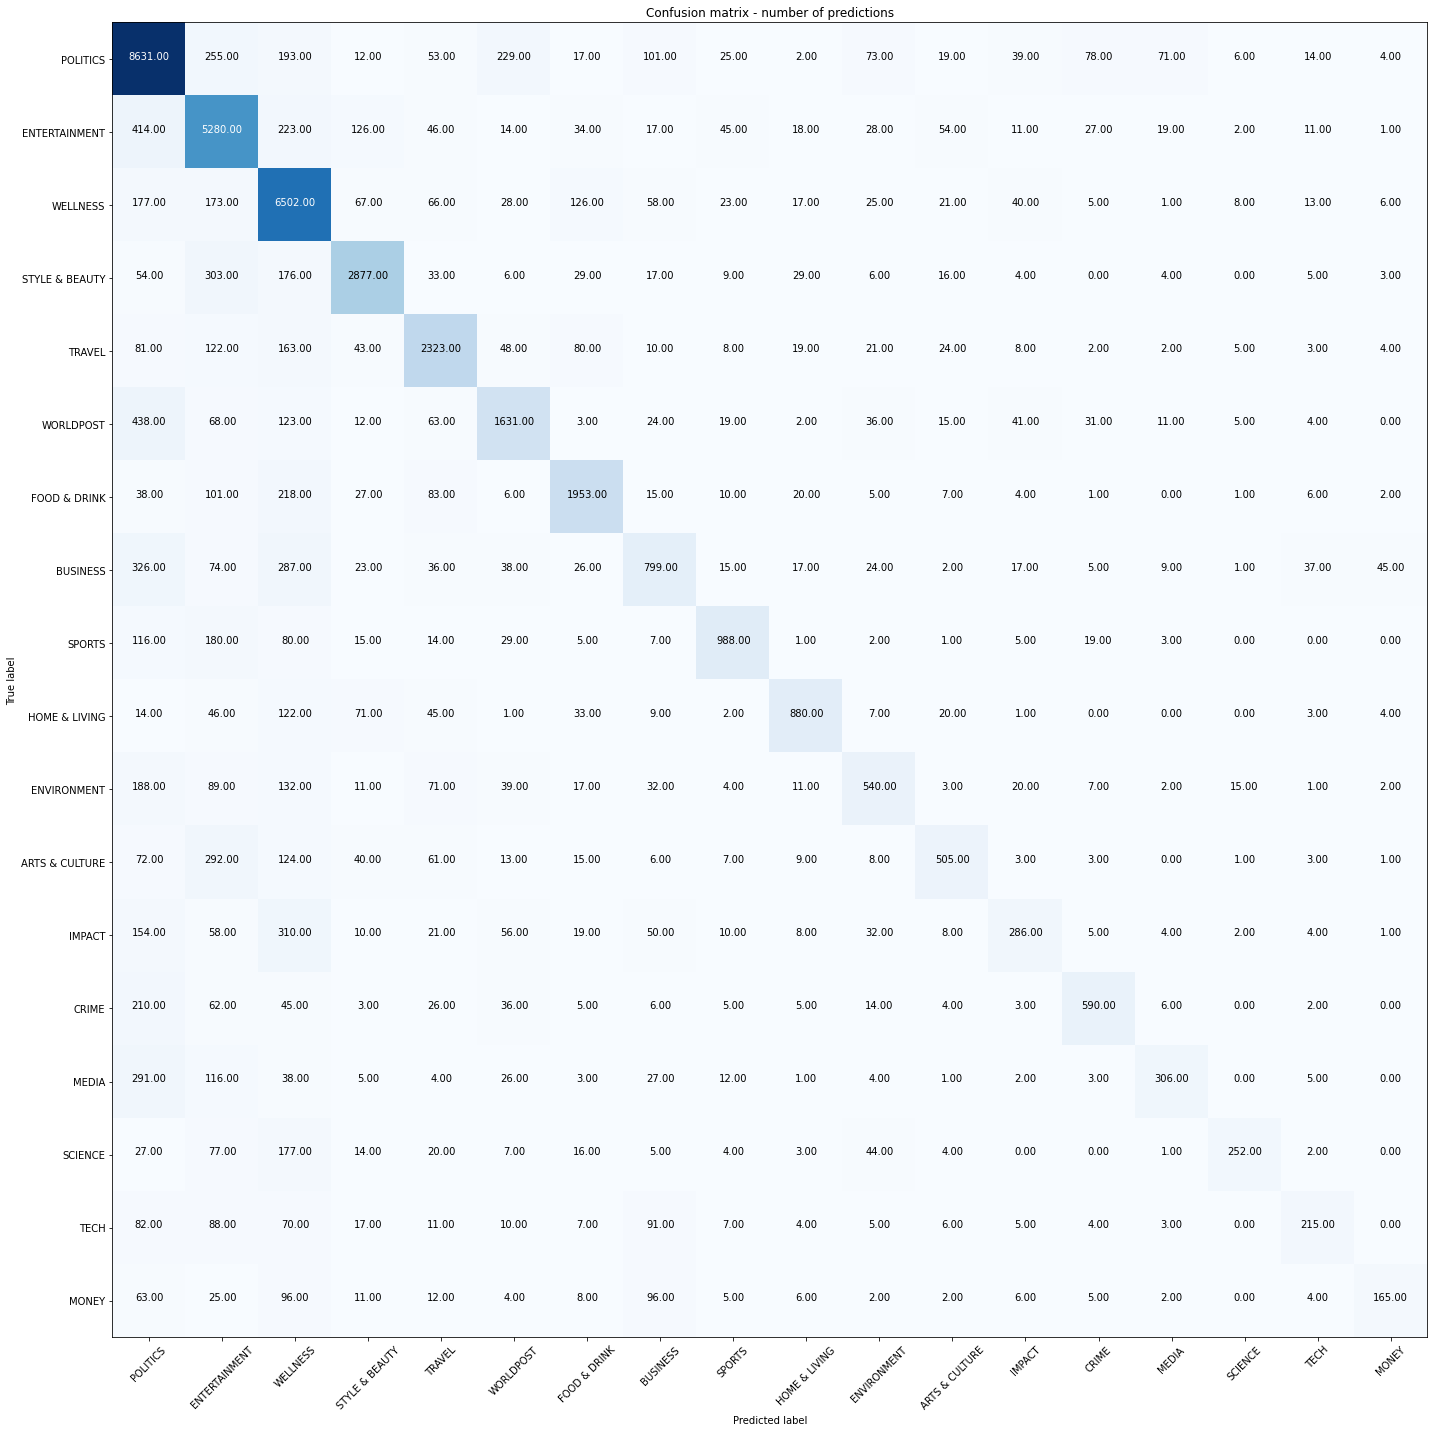

In [63]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Random Forest

## On stemmed data

In [64]:
rfc.fit(X_train_stem,y_train)

RandomForestClassifier()

In [65]:
y_pred_train=rfc.predict(X_train_stem)
y_pred_test=rfc.predict(X_test_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

rfc_bow_stem_acc_train = accuracy_score(y_train, y_pred_train)
rfc_bow_stem_acc_test =  accuracy_score(y_test, y_pred_test)
rfc_bow_stem_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9997335954509127
ACC test set: 0.663237090862324
Mislabeled no: 15711
                precision    recall  f1-score   support

ARTS & CULTURE       0.59      0.33      0.43      1163
      BUSINESS       0.51      0.33      0.40      1781
         CRIME       0.62      0.49      0.55      1022
 ENTERTAINMENT       0.62      0.73      0.67      6370
   ENVIRONMENT       0.53      0.23      0.32      1184
  FOOD & DRINK       0.72      0.75      0.74      2497
 HOME & LIVING       0.81      0.57      0.67      1258
        IMPACT       0.69      0.08      0.14      1038
         MEDIA       0.63      0.22      0.33       844
         MONEY       0.77      0.07      0.13       512
      POLITICS       0.69      0.88      0.77      9822
       SCIENCE       0.64      0.23      0.34       653
        SPORTS       0.72      0.55      0.62      1465
STYLE & BEAUTY       0.76      0.75      0.75      3571
          TECH       0.62      0.21      0.31       625
        TRAVEL  

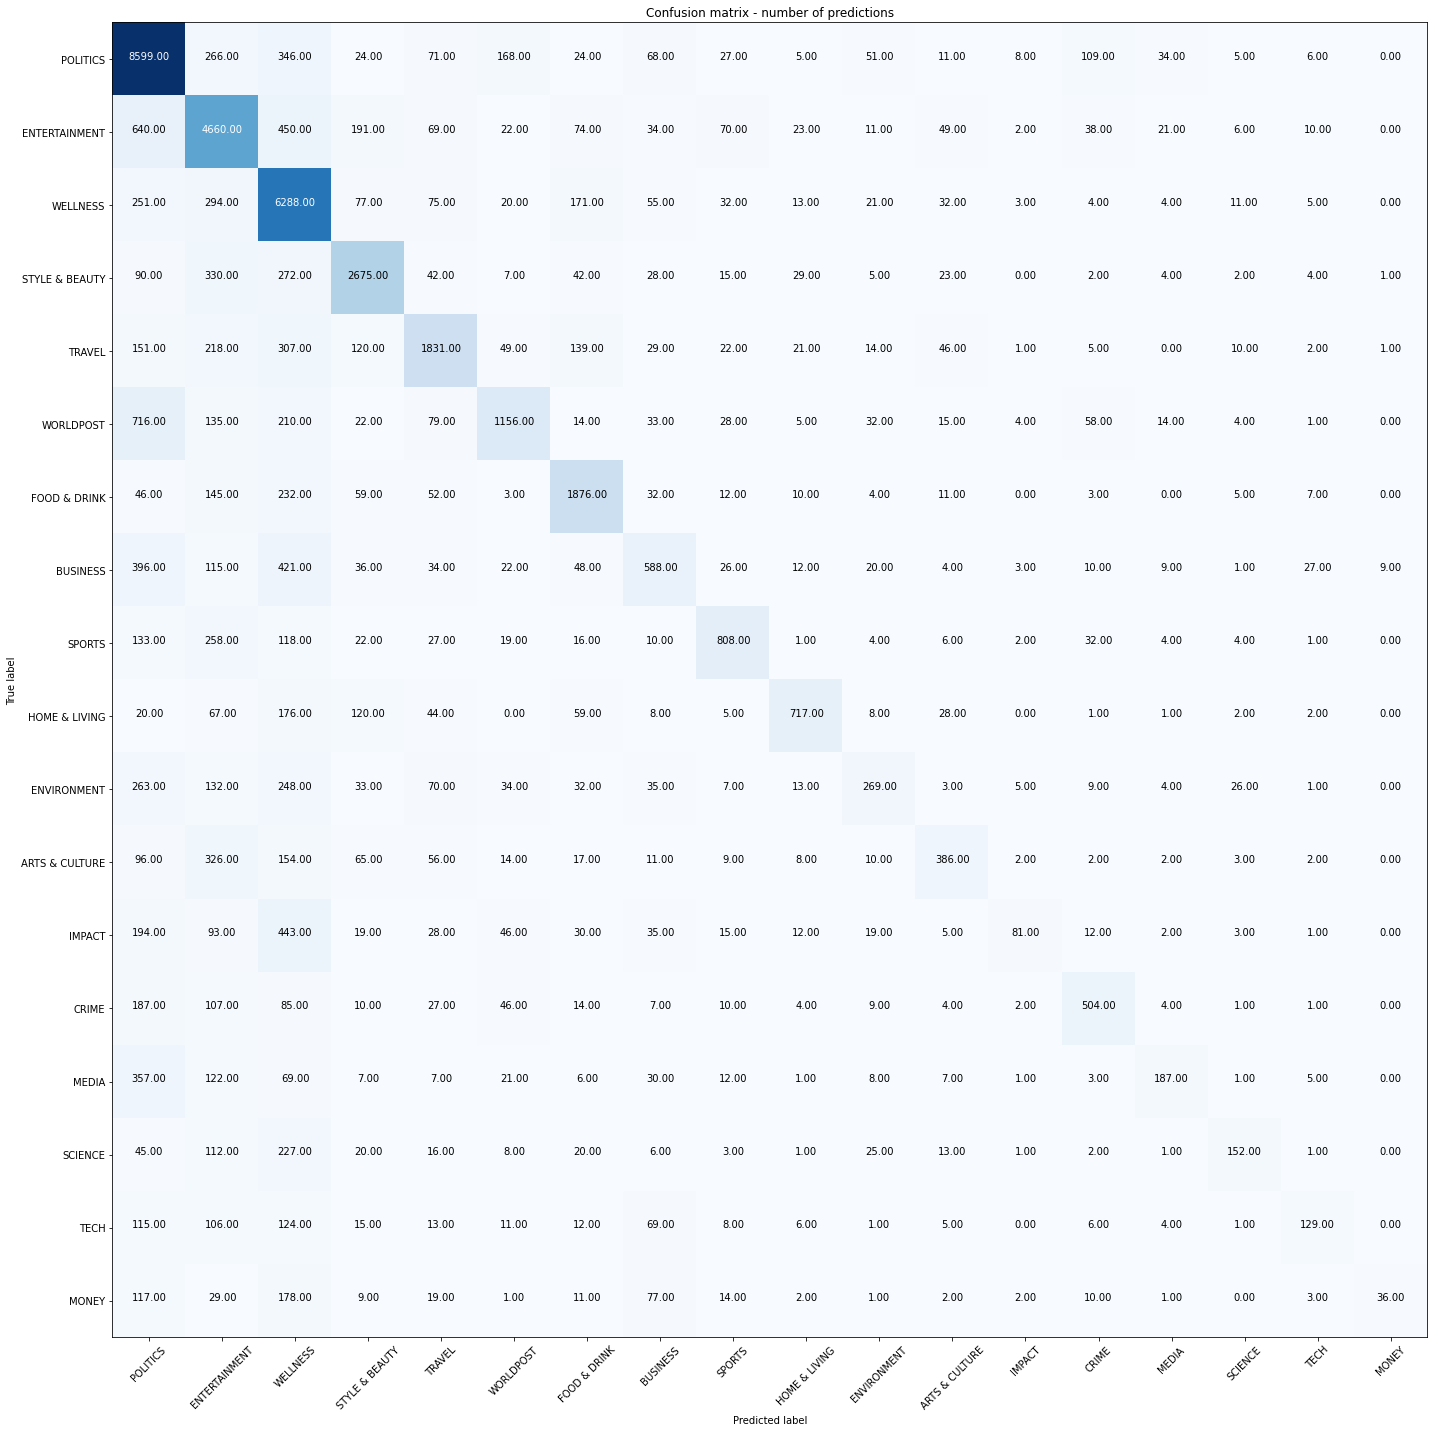

In [66]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## On lemmatized data

In [67]:
rfc.fit(X_train_lemma,y_train)

RandomForestClassifier()

In [68]:
y_pred_train=rfc.predict(X_train_lemma)
y_pred_test=rfc.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

rfc_bow_lemma_acc_train = accuracy_score(y_train, y_pred_train)
rfc_bow_lemma_acc_test =  accuracy_score(y_test, y_pred_test)
rfc_bow_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9997335954509127
ACC test set: 0.6650376181596039
Mislabeled no: 15627
                precision    recall  f1-score   support

ARTS & CULTURE       0.61      0.34      0.44      1163
      BUSINESS       0.49      0.35      0.41      1781
         CRIME       0.63      0.52      0.57      1022
 ENTERTAINMENT       0.61      0.74      0.67      6370
   ENVIRONMENT       0.51      0.27      0.36      1184
  FOOD & DRINK       0.72      0.75      0.73      2497
 HOME & LIVING       0.82      0.57      0.67      1258
        IMPACT       0.68      0.06      0.12      1038
         MEDIA       0.61      0.24      0.34       844
         MONEY       0.76      0.09      0.16       512
      POLITICS       0.71      0.87      0.78      9822
       SCIENCE       0.62      0.25      0.36       653
        SPORTS       0.72      0.56      0.63      1465
STYLE & BEAUTY       0.76      0.75      0.75      3571
          TECH       0.63      0.20      0.31       625
        TRAVEL 

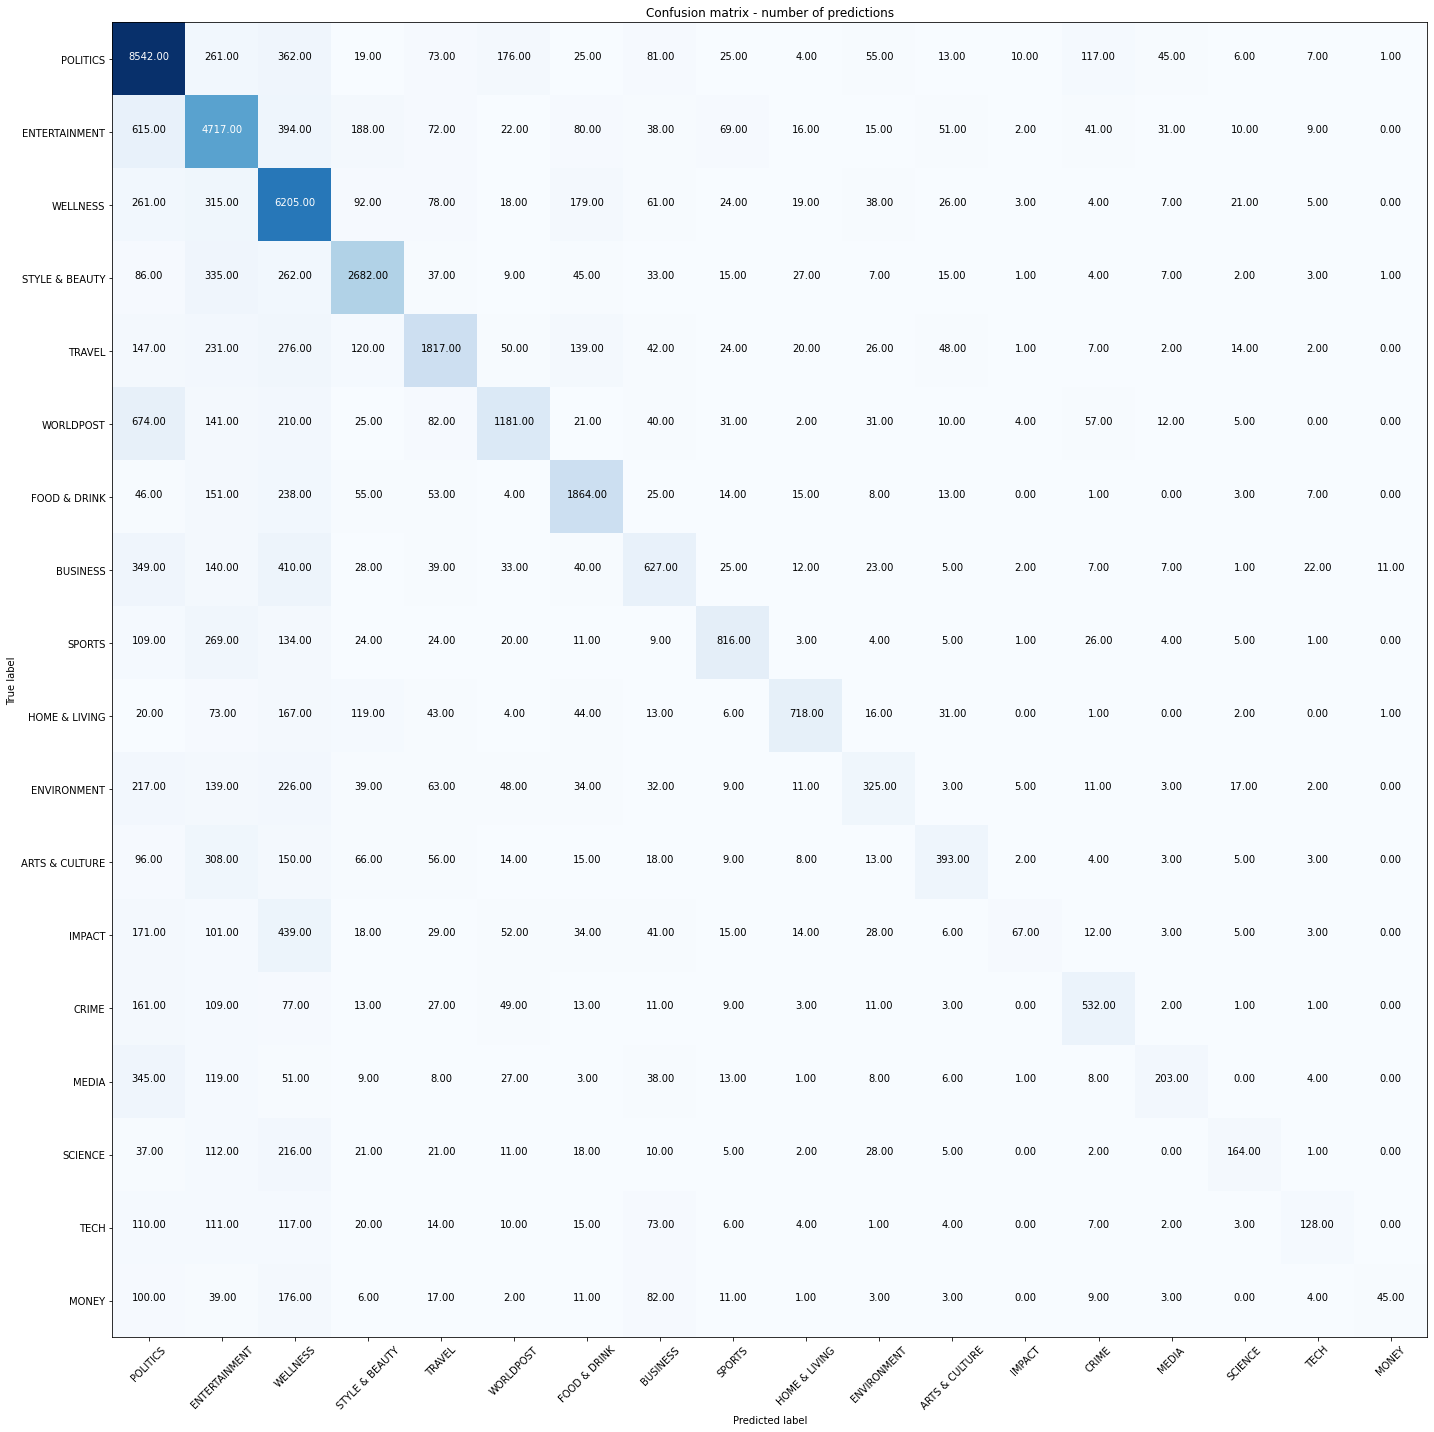

In [69]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFidf Stemmed data

In [70]:
rfc.fit(X_train_tfidf_stem,y_train)

RandomForestClassifier()

In [71]:
y_pred_train=rfc.predict(X_train_tfidf_stem)
y_pred_test=rfc.predict(X_test_tfidf_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

rfc_tfidf_stem_acc_train = accuracy_score(y_train, y_pred_train)
rfc_tfidf_stem_acc_test =  accuracy_score(y_test, y_pred_test)
rfc_tfidf_stem_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9997335954509127
ACC test set: 0.6625297408526782
Mislabeled no: 15744
                precision    recall  f1-score   support

ARTS & CULTURE       0.63      0.31      0.41      1163
      BUSINESS       0.55      0.32      0.40      1781
         CRIME       0.64      0.49      0.55      1022
 ENTERTAINMENT       0.62      0.73      0.67      6370
   ENVIRONMENT       0.60      0.25      0.35      1184
  FOOD & DRINK       0.72      0.75      0.74      2497
 HOME & LIVING       0.81      0.57      0.67      1258
        IMPACT       0.70      0.07      0.12      1038
         MEDIA       0.67      0.21      0.32       844
         MONEY       0.82      0.08      0.15       512
      POLITICS       0.69      0.88      0.77      9822
       SCIENCE       0.71      0.23      0.35       653
        SPORTS       0.74      0.54      0.62      1465
STYLE & BEAUTY       0.75      0.75      0.75      3571
          TECH       0.62      0.21      0.31       625
        TRAVEL 

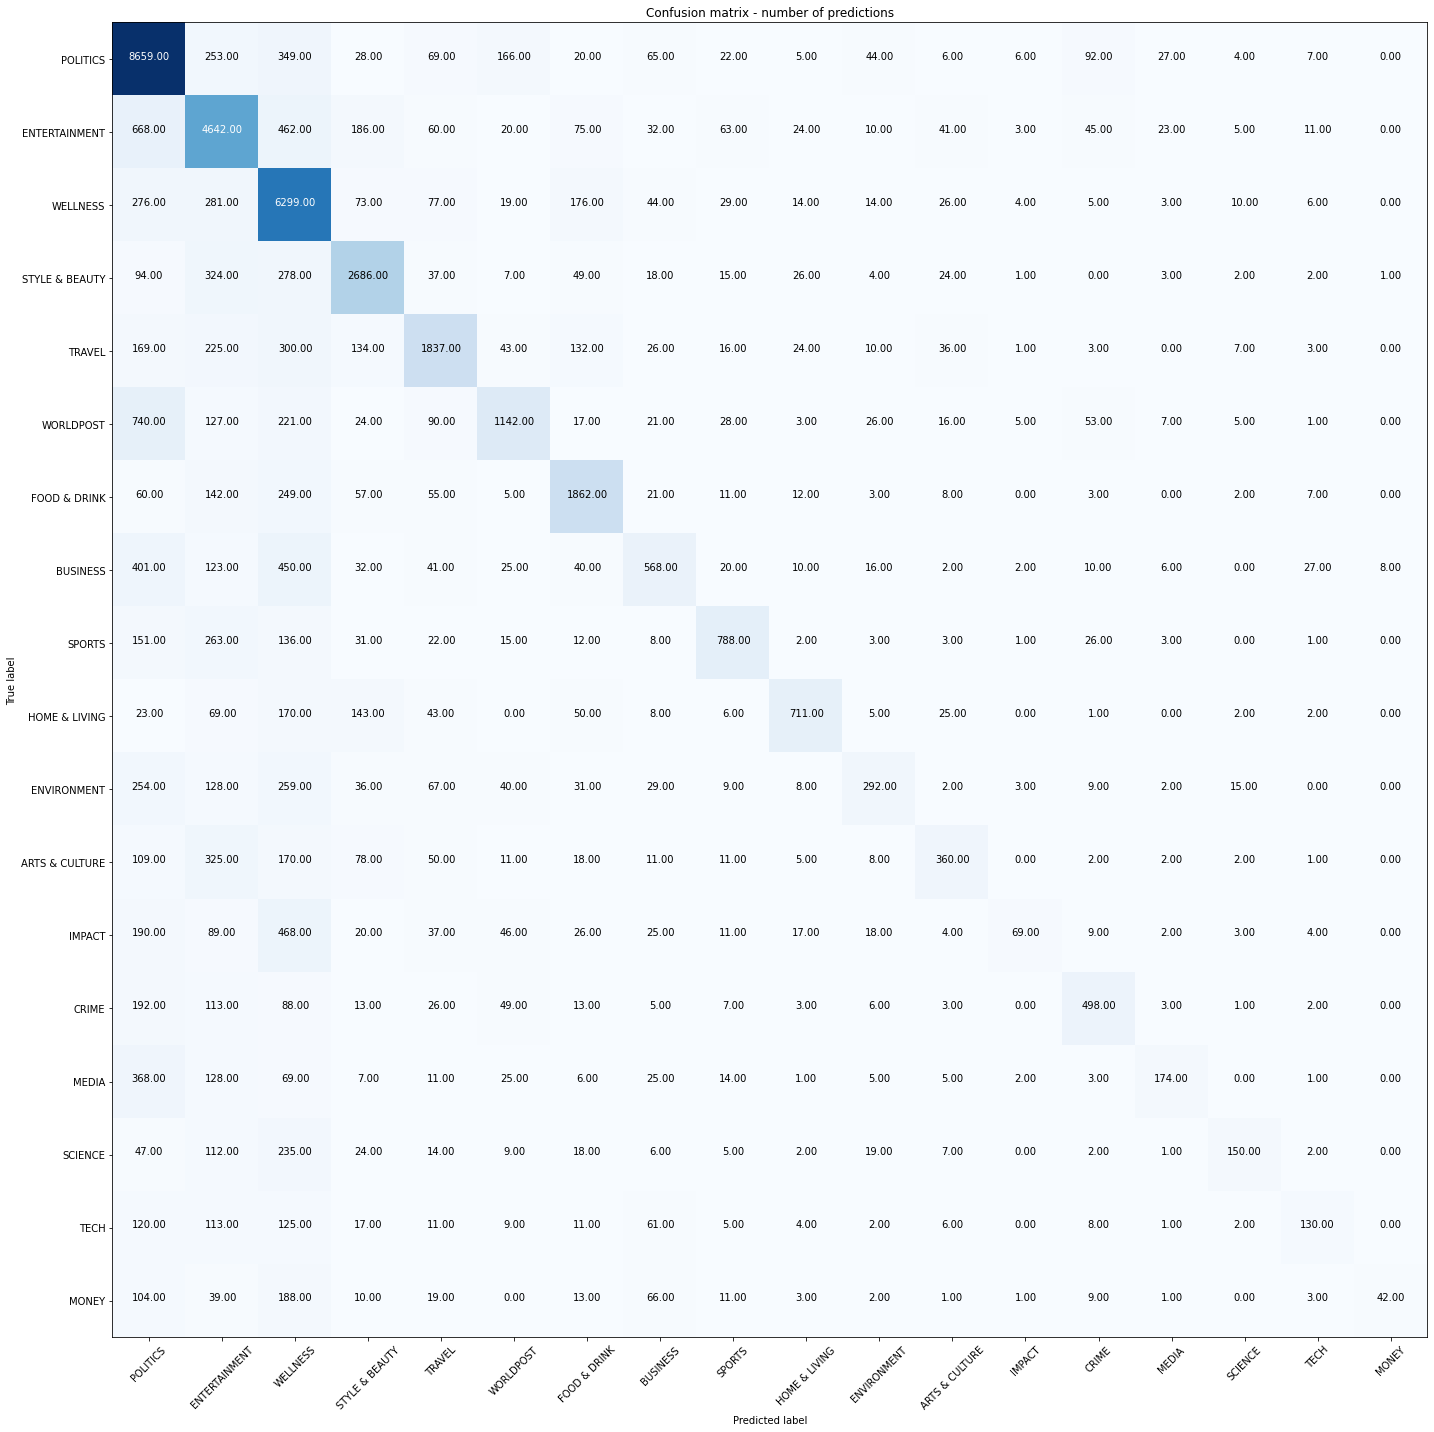

In [72]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF Lemmatized data

In [73]:
rfc.fit(X_train_tfidf_lemma,y_train)

RandomForestClassifier()

In [74]:
y_pred_train=rfc.predict(X_train_tfidf_lemma)
y_pred_test=rfc.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))


rfc_tfidf_lemma_acc_train = accuracy_score(y_train, y_pred_train)
rfc_tfidf_lemma_acc_test =  accuracy_score(y_test, y_pred_test)
rfc_tfidf_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))


ACC train set: 0.9997427818146744
ACC test set: 0.6634514393500954
Mislabeled no: 15701
                precision    recall  f1-score   support

ARTS & CULTURE       0.64      0.33      0.43      1163
      BUSINESS       0.55      0.33      0.41      1781
         CRIME       0.64      0.50      0.56      1022
 ENTERTAINMENT       0.62      0.74      0.67      6370
   ENVIRONMENT       0.60      0.26      0.36      1184
  FOOD & DRINK       0.73      0.74      0.73      2497
 HOME & LIVING       0.80      0.55      0.66      1258
        IMPACT       0.75      0.07      0.12      1038
         MEDIA       0.70      0.24      0.35       844
         MONEY       0.75      0.10      0.18       512
      POLITICS       0.70      0.87      0.77      9822
       SCIENCE       0.65      0.25      0.36       653
        SPORTS       0.72      0.55      0.62      1465
STYLE & BEAUTY       0.76      0.75      0.76      3571
          TECH       0.59      0.23      0.33       625
        TRAVEL 

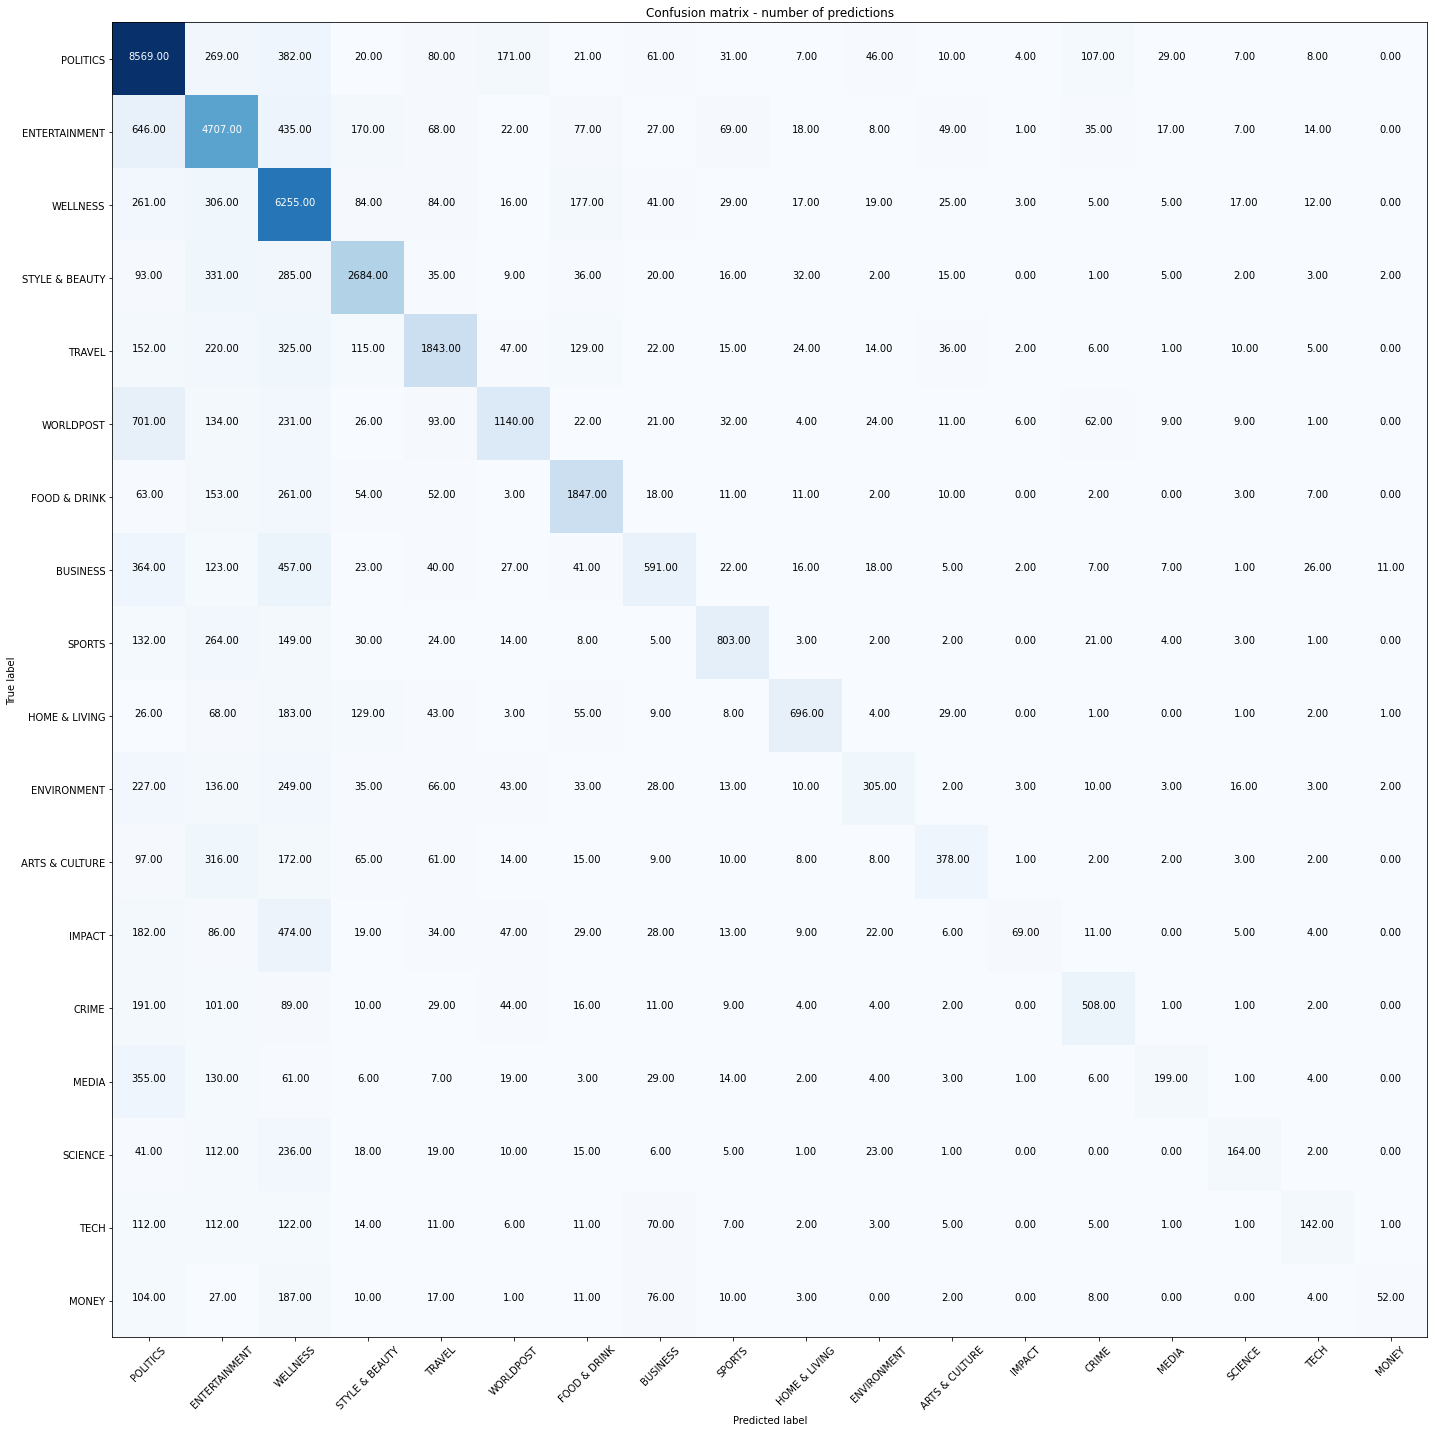

In [75]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# SGDClassifier

In [76]:
sgdc_model=SGDClassifier()

## Bag of words ngram (1,2) stemmed data

In [77]:
sgdc_model.fit(X_train_stem,y_train)

SGDClassifier()

In [78]:
y_pred_train=sgdc_model.predict(X_train_stem)
y_pred_test=sgdc_model.predict(X_test_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

sgdc_bow_stem_train_acc = accuracy_score(y_train, y_pred_train)
sgdc_bow_stem_test_acc = accuracy_score(y_test, y_pred_test)
sgdc_bow_stem_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))


ACC train set: 0.8809263529217229
ACC test set: 0.7407669388892462
Mislabeled no: 12094
                precision    recall  f1-score   support

ARTS & CULTURE       0.65      0.49      0.56      1163
      BUSINESS       0.58      0.43      0.49      1781
         CRIME       0.70      0.56      0.62      1022
 ENTERTAINMENT       0.73      0.81      0.77      6370
   ENVIRONMENT       0.60      0.44      0.51      1184
  FOOD & DRINK       0.75      0.82      0.78      2497
 HOME & LIVING       0.80      0.71      0.75      1258
        IMPACT       0.54      0.26      0.35      1038
         MEDIA       0.64      0.36      0.46       844
         MONEY       0.61      0.40      0.48       512
      POLITICS       0.77      0.87      0.82      9822
       SCIENCE       0.73      0.42      0.53       653
        SPORTS       0.73      0.75      0.74      1465
STYLE & BEAUTY       0.84      0.81      0.82      3571
          TECH       0.60      0.40      0.48       625
        TRAVEL 

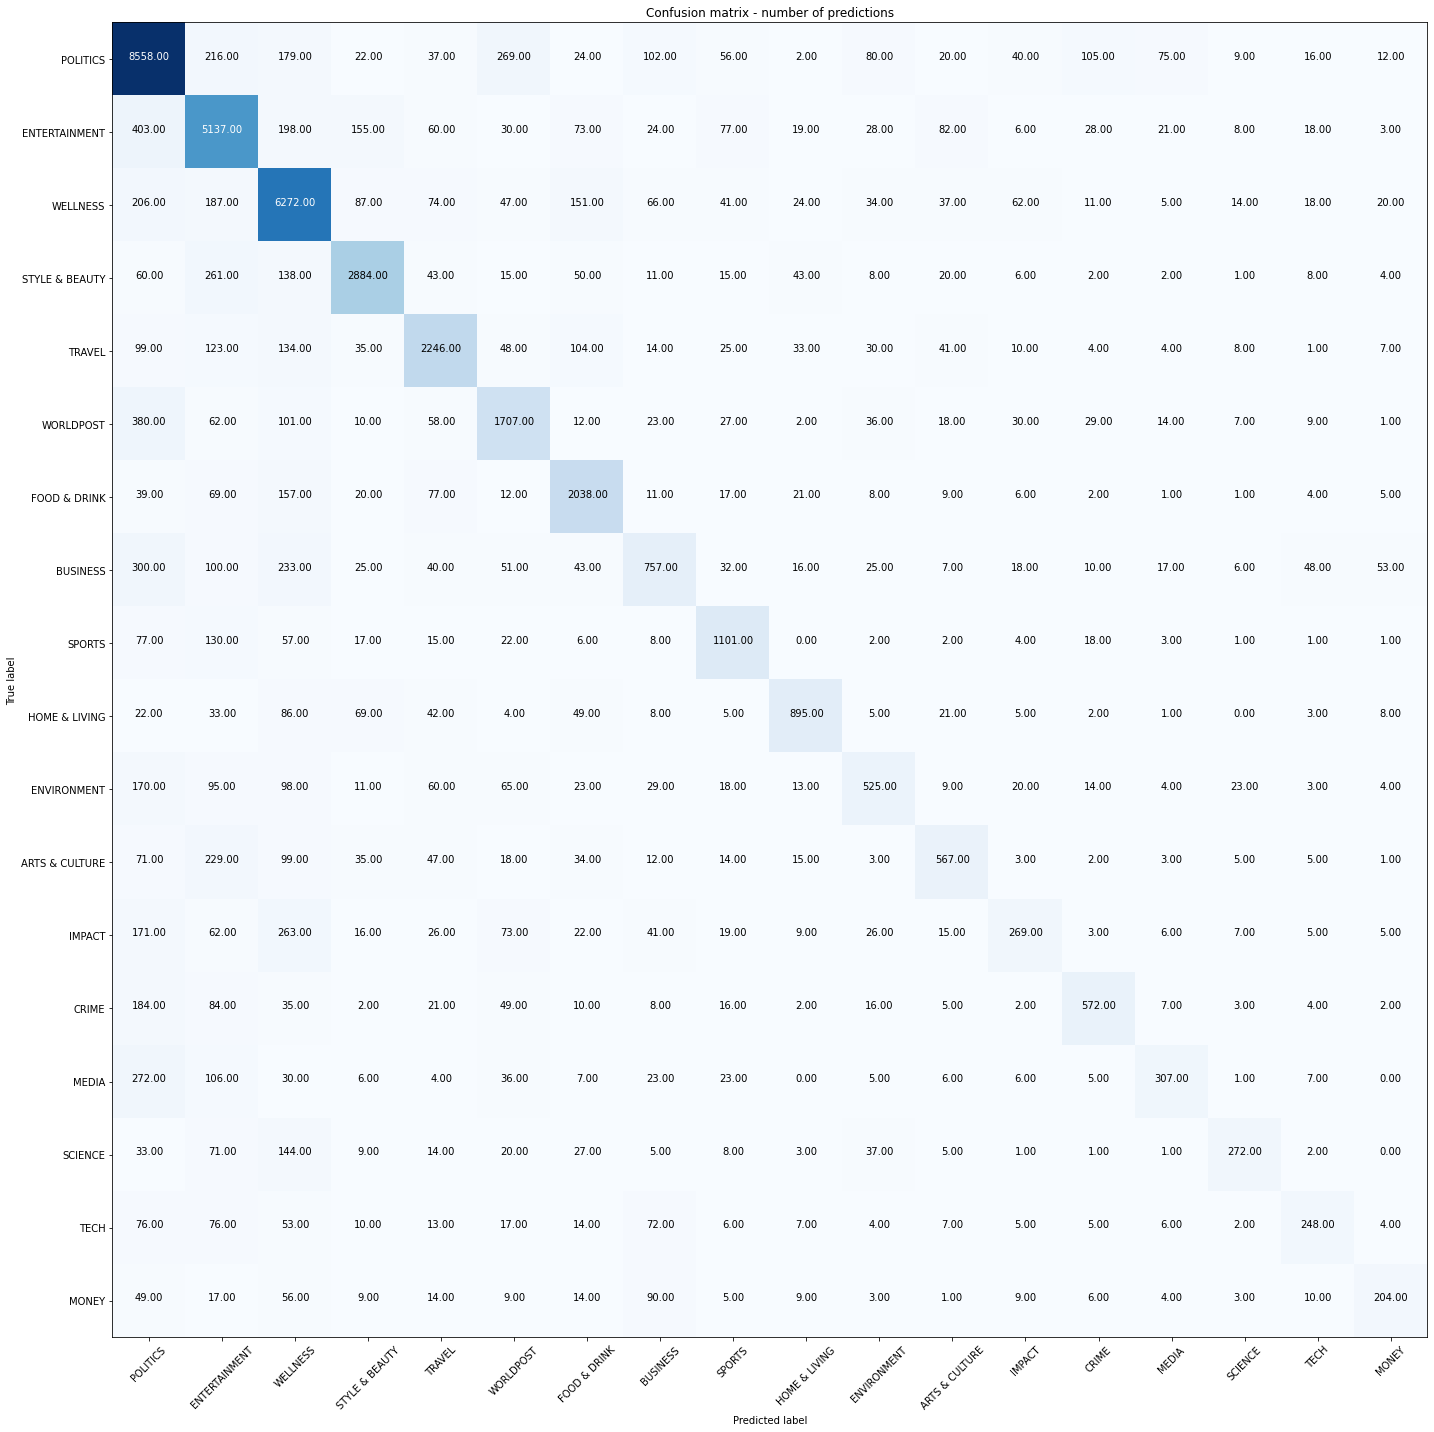

In [79]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Bag of words ngram (1,2) lemmatized data

In [80]:
sgdc_model.fit(X_train_lemma,y_train)

SGDClassifier()

In [81]:
y_pred_train=sgdc_model.predict(X_train_lemma)
y_pred_test=sgdc_model.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

sgdc_bow_lemma_train_acc = accuracy_score(y_train, y_pred_train)
sgdc_bow_lemma_test_acc = accuracy_score(y_test, y_pred_test)
sgdc_bow_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.888146834838366
ACC test set: 0.7438535571131546
Mislabeled no: 11950
                precision    recall  f1-score   support

ARTS & CULTURE       0.64      0.49      0.56      1163
      BUSINESS       0.56      0.45      0.50      1781
         CRIME       0.70      0.61      0.65      1022
 ENTERTAINMENT       0.73      0.81      0.77      6370
   ENVIRONMENT       0.60      0.45      0.51      1184
  FOOD & DRINK       0.75      0.82      0.78      2497
 HOME & LIVING       0.82      0.70      0.75      1258
        IMPACT       0.54      0.28      0.37      1038
         MEDIA       0.64      0.39      0.48       844
         MONEY       0.63      0.38      0.48       512
      POLITICS       0.77      0.87      0.82      9822
       SCIENCE       0.73      0.42      0.53       653
        SPORTS       0.74      0.76      0.75      1465
STYLE & BEAUTY       0.84      0.82      0.83      3571
          TECH       0.60      0.39      0.47       625
        TRAVEL  

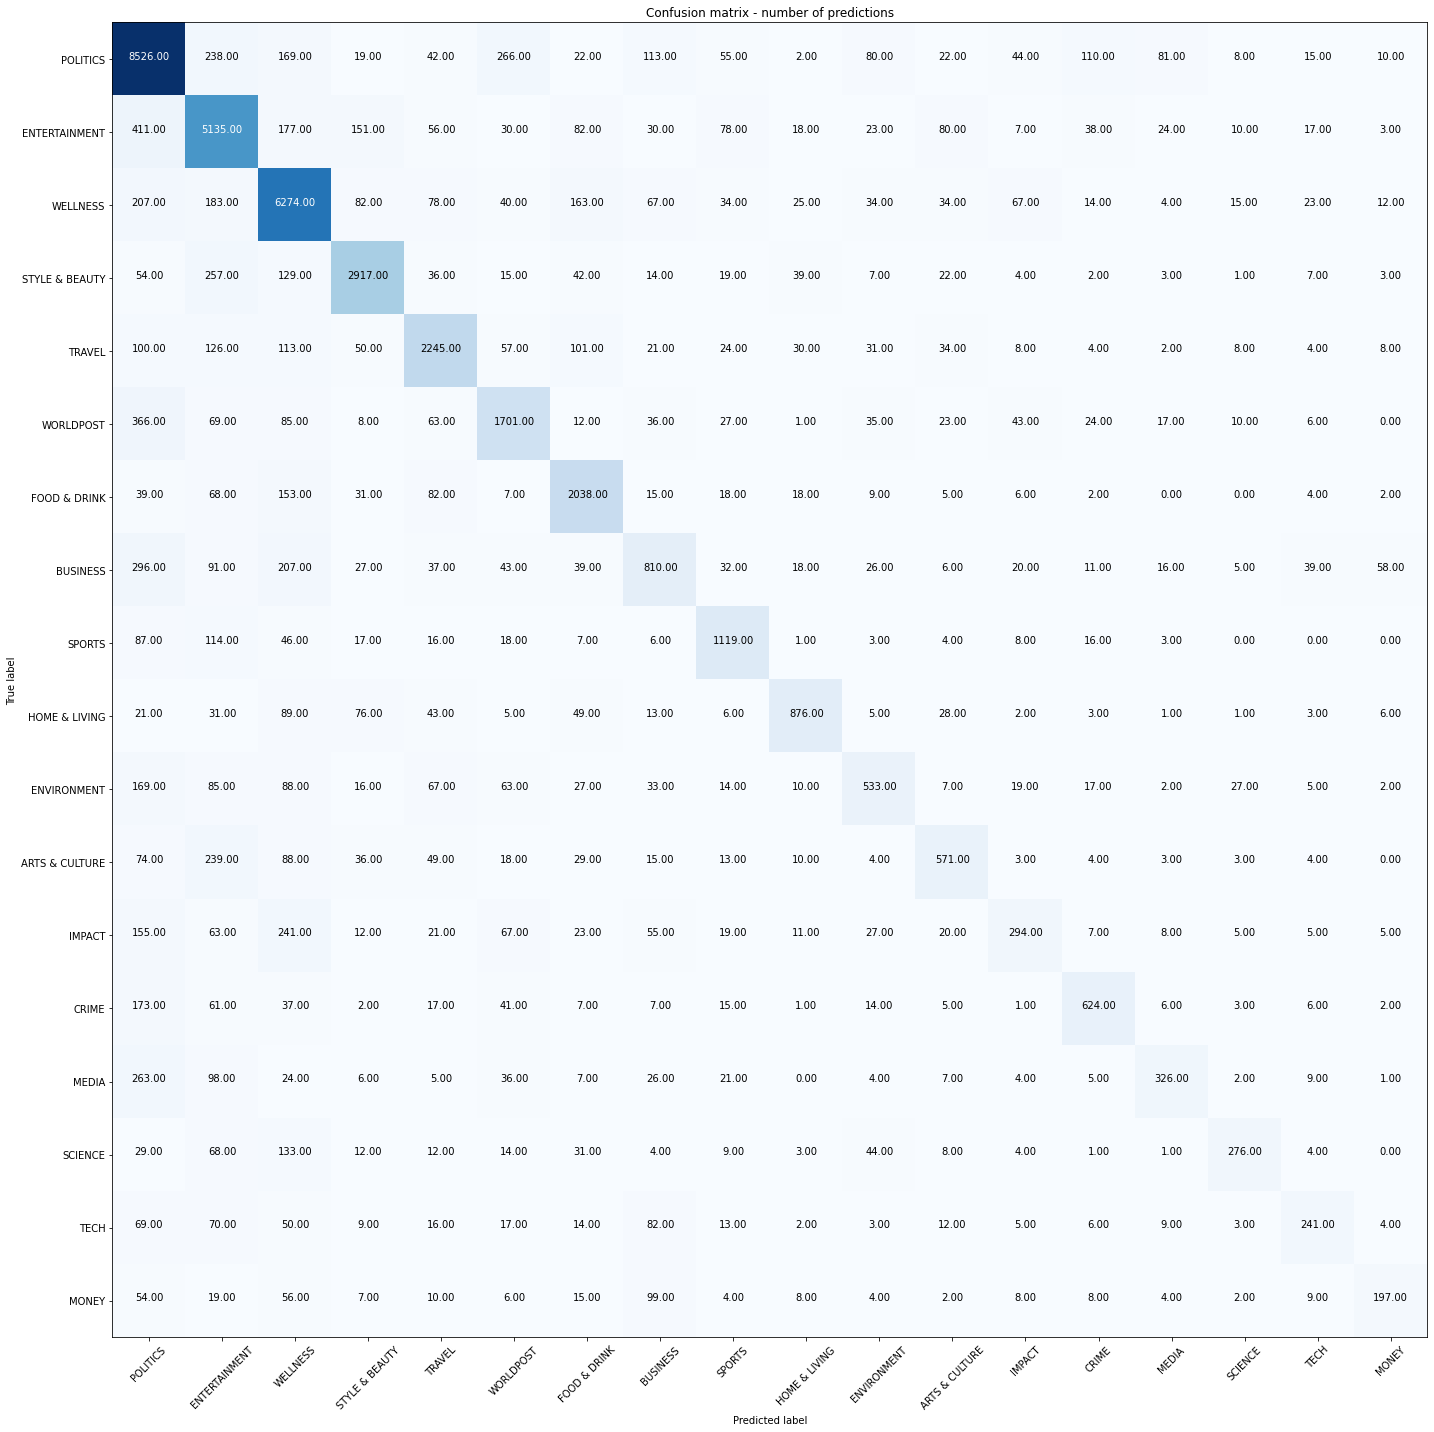

In [82]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF Stemmed data

In [83]:
sgdc_model.fit(X_train_tfidf_stem,y_train)

SGDClassifier()

In [84]:
y_pred_train=sgdc_model.predict(X_train_tfidf_stem)
y_pred_test=sgdc_model.predict(X_test_tfidf_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

sgdc_tfidf_stem_train_acc = accuracy_score(y_train, y_pred_train)
sgdc_tfidf_stem_test_acc = accuracy_score(y_test, y_pred_test)
sgdc_tfidf_stem_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.7811716288341586
ACC test set: 0.7232332325895441
Mislabeled no: 12912
                precision    recall  f1-score   support

ARTS & CULTURE       0.70      0.37      0.48      1163
      BUSINESS       0.67      0.31      0.42      1781
         CRIME       0.69      0.54      0.61      1022
 ENTERTAINMENT       0.73      0.78      0.75      6370
   ENVIRONMENT       0.64      0.32      0.43      1184
  FOOD & DRINK       0.77      0.81      0.79      2497
 HOME & LIVING       0.79      0.68      0.73      1258
        IMPACT       0.65      0.13      0.21      1038
         MEDIA       0.75      0.25      0.37       844
         MONEY       0.68      0.26      0.38       512
      POLITICS       0.72      0.90      0.80      9822
       SCIENCE       0.76      0.33      0.46       653
        SPORTS       0.77      0.69      0.73      1465
STYLE & BEAUTY       0.79      0.81      0.80      3571
          TECH       0.60      0.34      0.43       625
        TRAVEL 

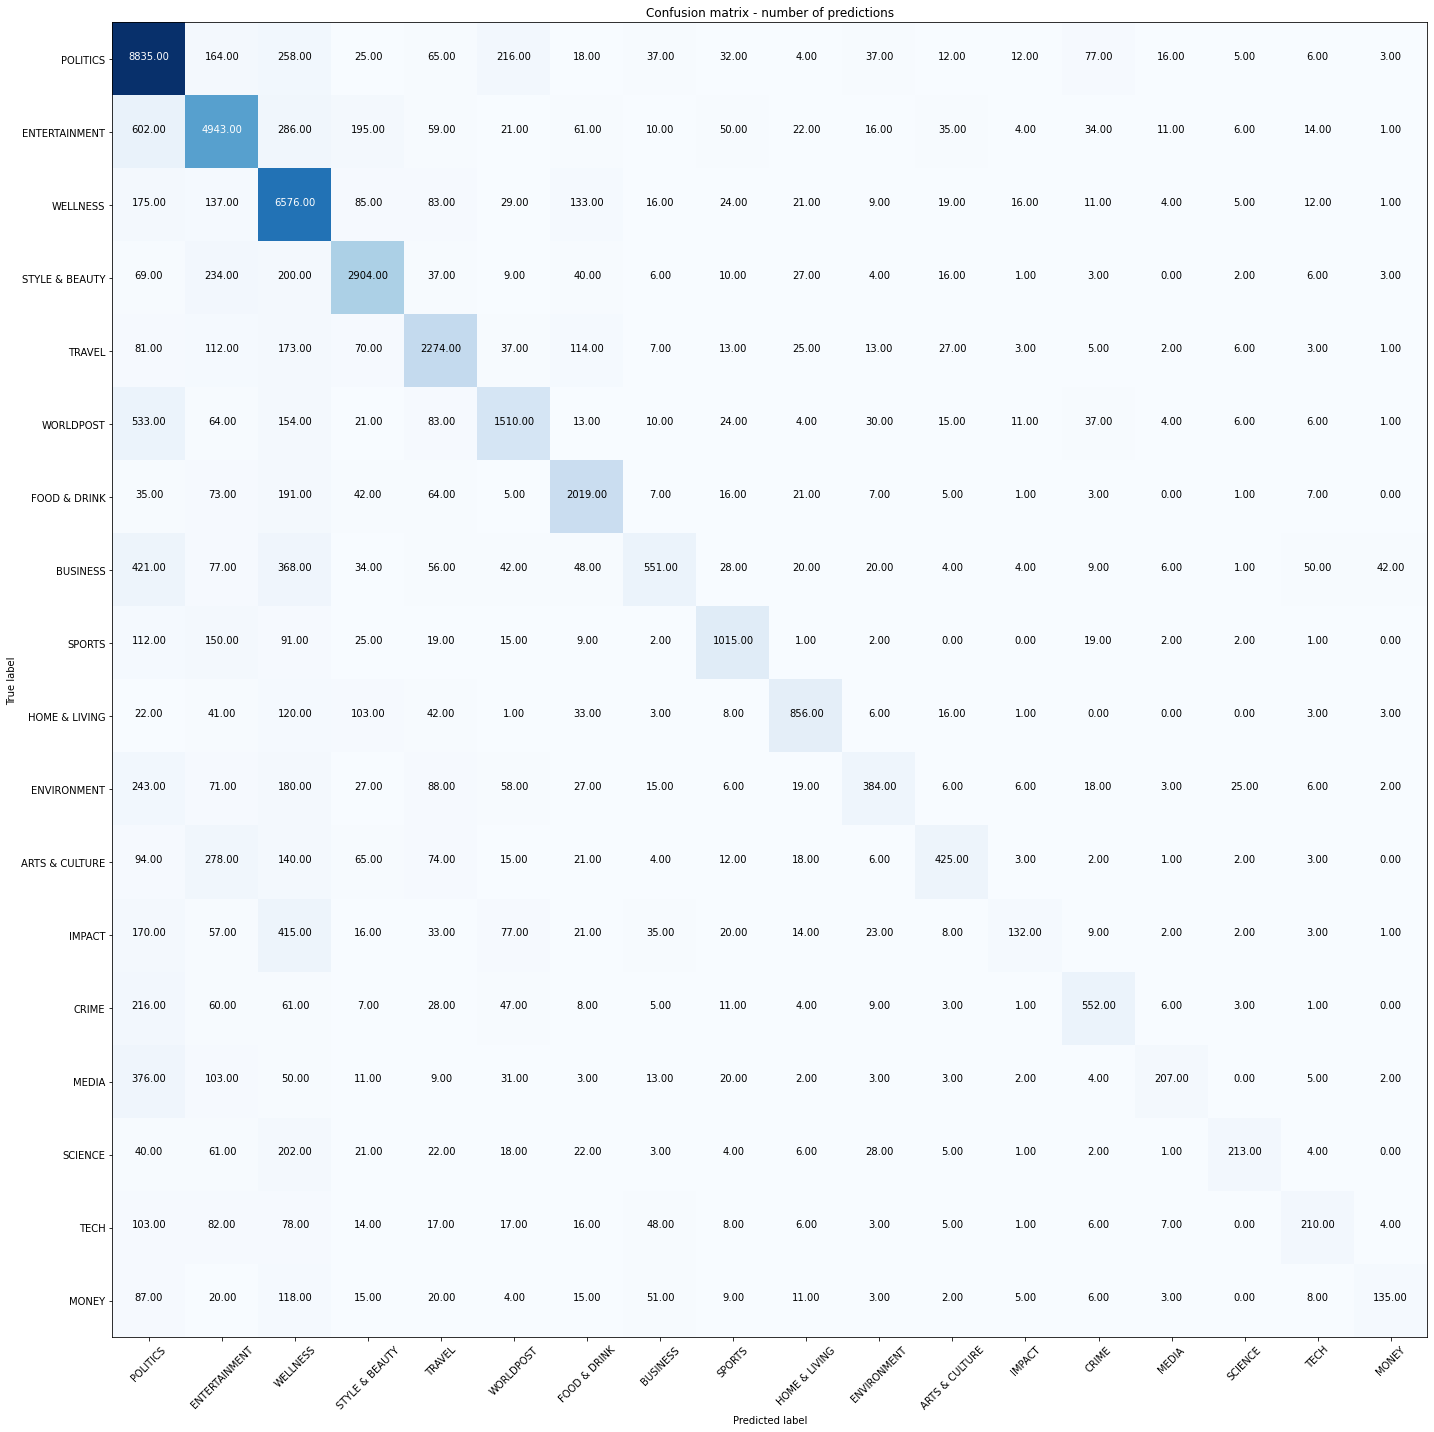

In [85]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF lemmatized data

In [86]:
sgdc_model.fit(X_train_tfidf_lemma,y_train)

SGDClassifier()

In [87]:
y_pred_train=sgdc_model.predict(X_train_tfidf_lemma)
y_pred_test=sgdc_model.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

sgdc_tfidf_lemma_train_acc = accuracy_score(y_train, y_pred_train)
sgdc_tfidf_lemma_test_acc = accuracy_score(y_test, y_pred_test)
sgdc_tfidf_lemma_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.7863343652681959
ACC test set: 0.7244335841210641
Mislabeled no: 12856
                precision    recall  f1-score   support

ARTS & CULTURE       0.72      0.36      0.48      1163
      BUSINESS       0.67      0.32      0.43      1781
         CRIME       0.72      0.55      0.62      1022
 ENTERTAINMENT       0.73      0.78      0.76      6370
   ENVIRONMENT       0.62      0.32      0.42      1184
  FOOD & DRINK       0.77      0.80      0.79      2497
 HOME & LIVING       0.79      0.68      0.73      1258
        IMPACT       0.68      0.13      0.22      1038
         MEDIA       0.76      0.26      0.38       844
         MONEY       0.69      0.24      0.36       512
      POLITICS       0.72      0.90      0.80      9822
       SCIENCE       0.74      0.32      0.45       653
        SPORTS       0.78      0.70      0.74      1465
STYLE & BEAUTY       0.79      0.82      0.81      3571
          TECH       0.63      0.33      0.43       625
        TRAVEL 

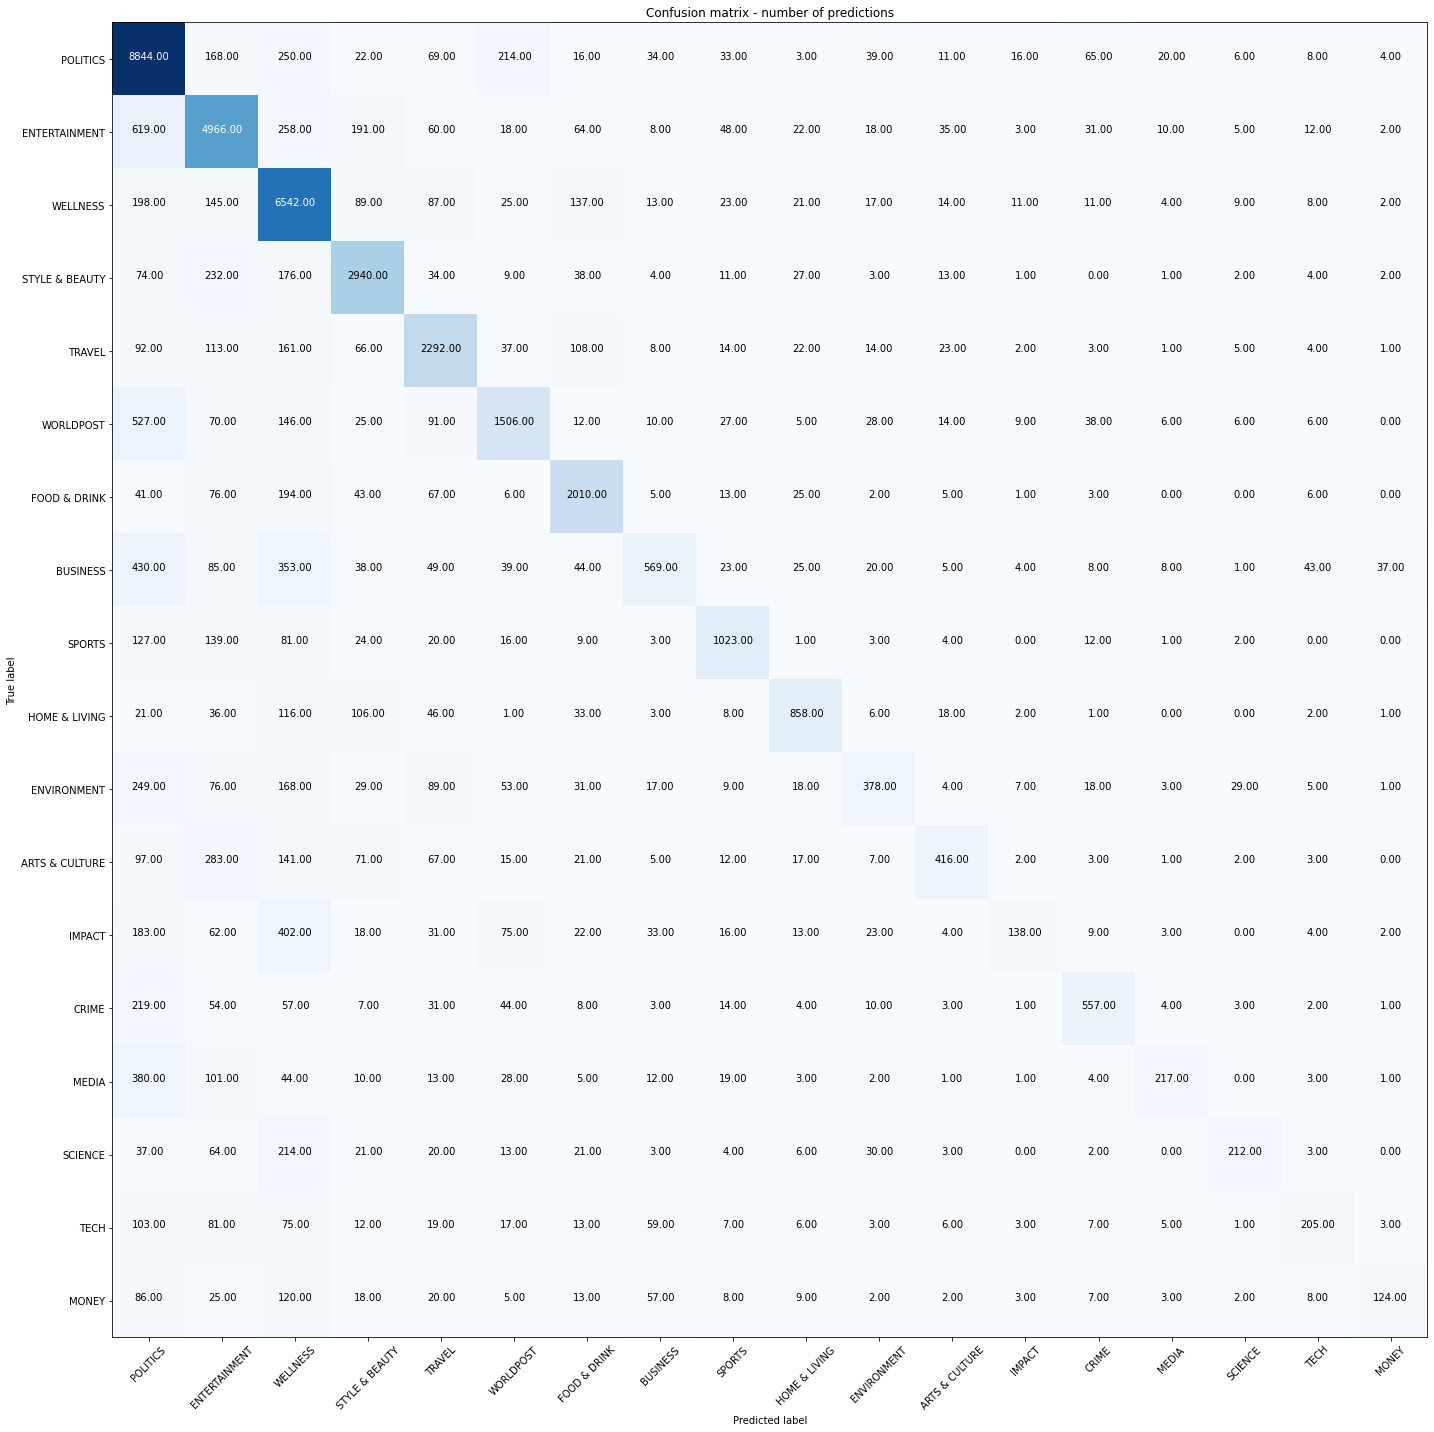

In [88]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Linear SVC

## Bag of words ngram(1,2) stemmed data

In [89]:
svm = LinearSVC()
svm.fit(X_train_stem,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC()

In [90]:
y_pred_train=svm.predict(X_train_stem)
y_pred_test=svm.predict(X_test_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

svm_stem_train_acc = accuracy_score(y_train, y_pred_train)
svm_stem_test_acc = accuracy_score(y_test, y_pred_test)
svm_stem_bow_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9964724363155332
ACC test set: 0.7010695989539794
Mislabeled no: 13946
                precision    recall  f1-score   support

ARTS & CULTURE       0.52      0.48      0.50      1163
      BUSINESS       0.46      0.43      0.45      1781
         CRIME       0.61      0.60      0.61      1022
 ENTERTAINMENT       0.72      0.75      0.74      6370
   ENVIRONMENT       0.49      0.46      0.47      1184
  FOOD & DRINK       0.75      0.75      0.75      2497
 HOME & LIVING       0.76      0.70      0.73      1258
        IMPACT       0.34      0.30      0.32      1038
         MEDIA       0.49      0.42      0.45       844
         MONEY       0.46      0.37      0.41       512
      POLITICS       0.77      0.81      0.79      9822
       SCIENCE       0.52      0.45      0.48       653
        SPORTS       0.71      0.70      0.70      1465
STYLE & BEAUTY       0.80      0.80      0.80      3571
          TECH       0.49      0.42      0.45       625
        TRAVEL 

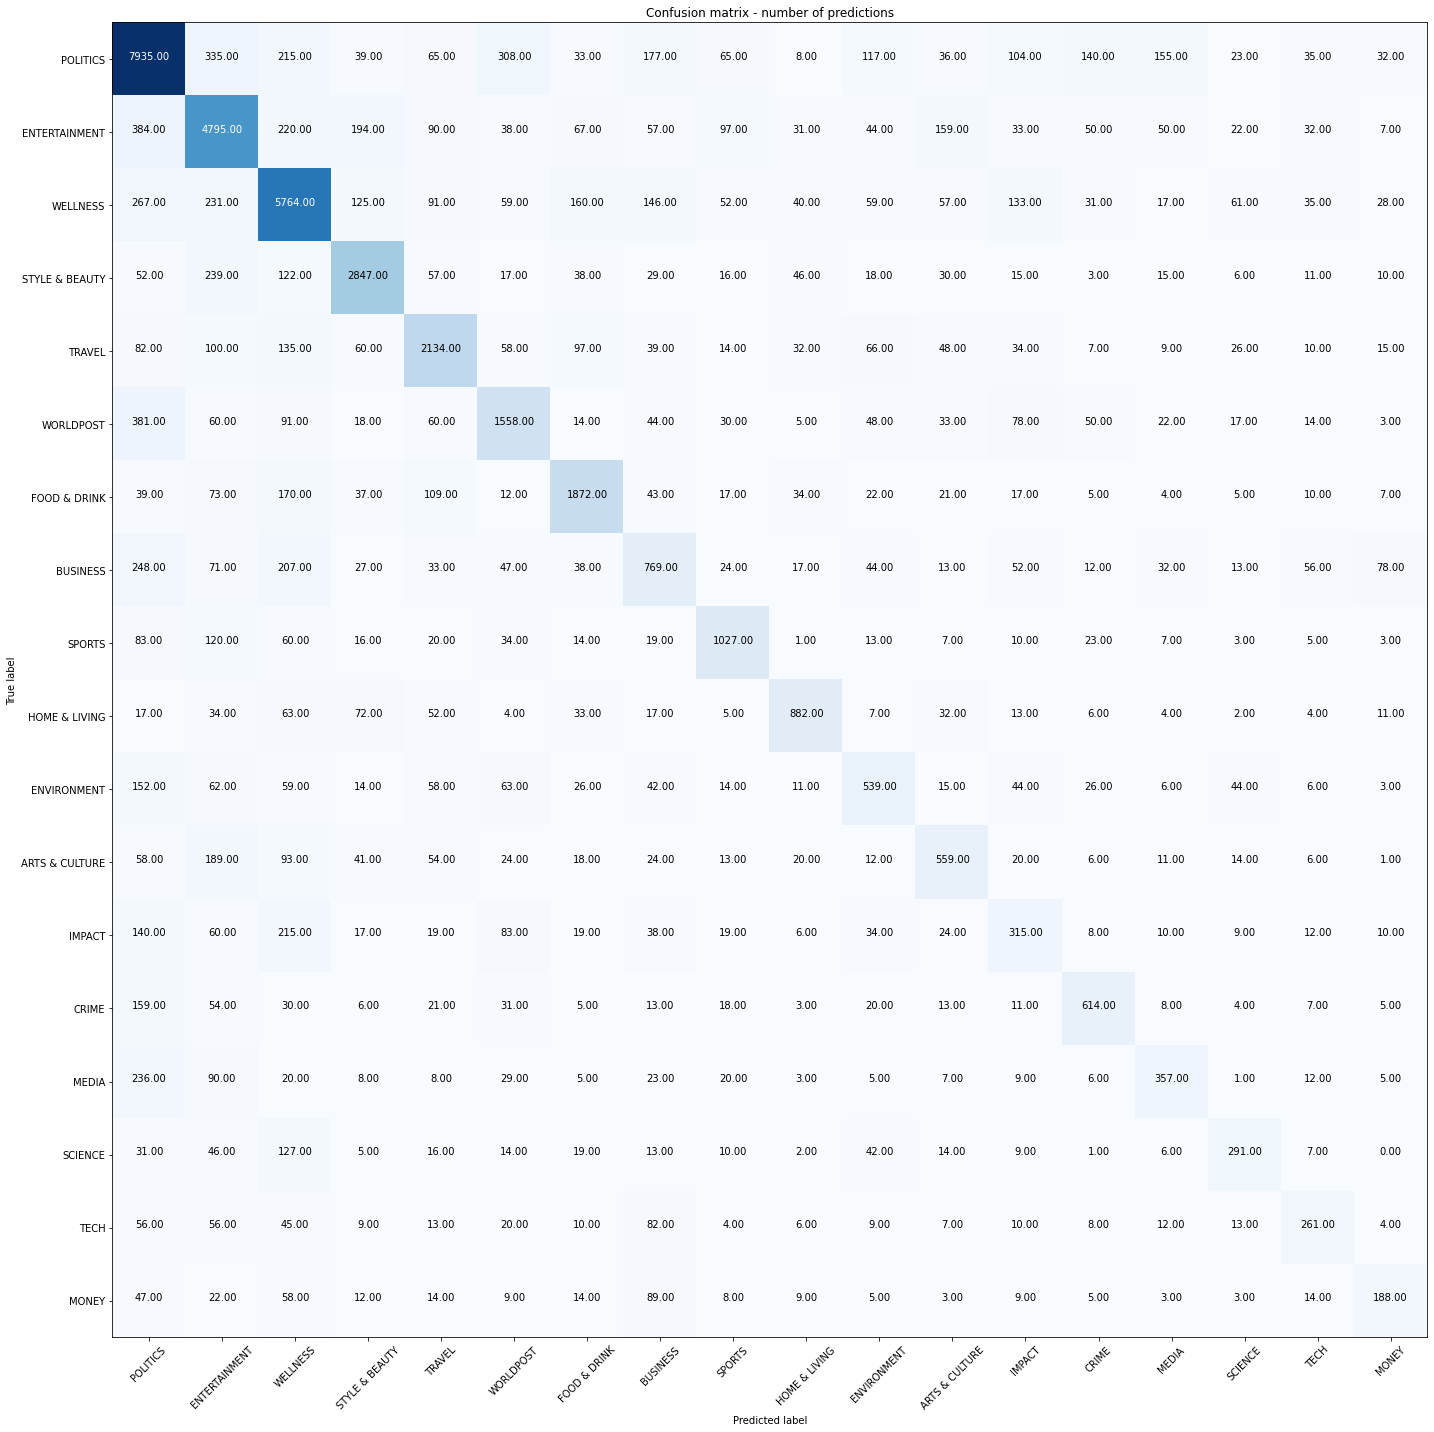

In [91]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Bag of words ngram(1,2) lemmatized data

In [92]:
svm.fit(X_train_lemma,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC()

In [93]:
y_pred_train=svm.predict(X_train_lemma)
y_pred_test=svm.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

svm_lemma_train_acc = accuracy_score(y_train, y_pred_train)
svm_lemma_test_acc = accuracy_score(y_test, y_pred_test)
svm_lemma_bow_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9968858226848066
ACC test set: 0.7035346065633507
Mislabeled no: 13831
                precision    recall  f1-score   support

ARTS & CULTURE       0.52      0.48      0.50      1163
      BUSINESS       0.45      0.44      0.45      1781
         CRIME       0.62      0.60      0.61      1022
 ENTERTAINMENT       0.73      0.76      0.74      6370
   ENVIRONMENT       0.50      0.44      0.47      1184
  FOOD & DRINK       0.76      0.76      0.76      2497
 HOME & LIVING       0.76      0.71      0.74      1258
        IMPACT       0.34      0.31      0.32      1038
         MEDIA       0.50      0.45      0.47       844
         MONEY       0.45      0.35      0.39       512
      POLITICS       0.77      0.81      0.79      9822
       SCIENCE       0.52      0.46      0.49       653
        SPORTS       0.73      0.69      0.71      1465
STYLE & BEAUTY       0.81      0.80      0.80      3571
          TECH       0.49      0.39      0.43       625
        TRAVEL 

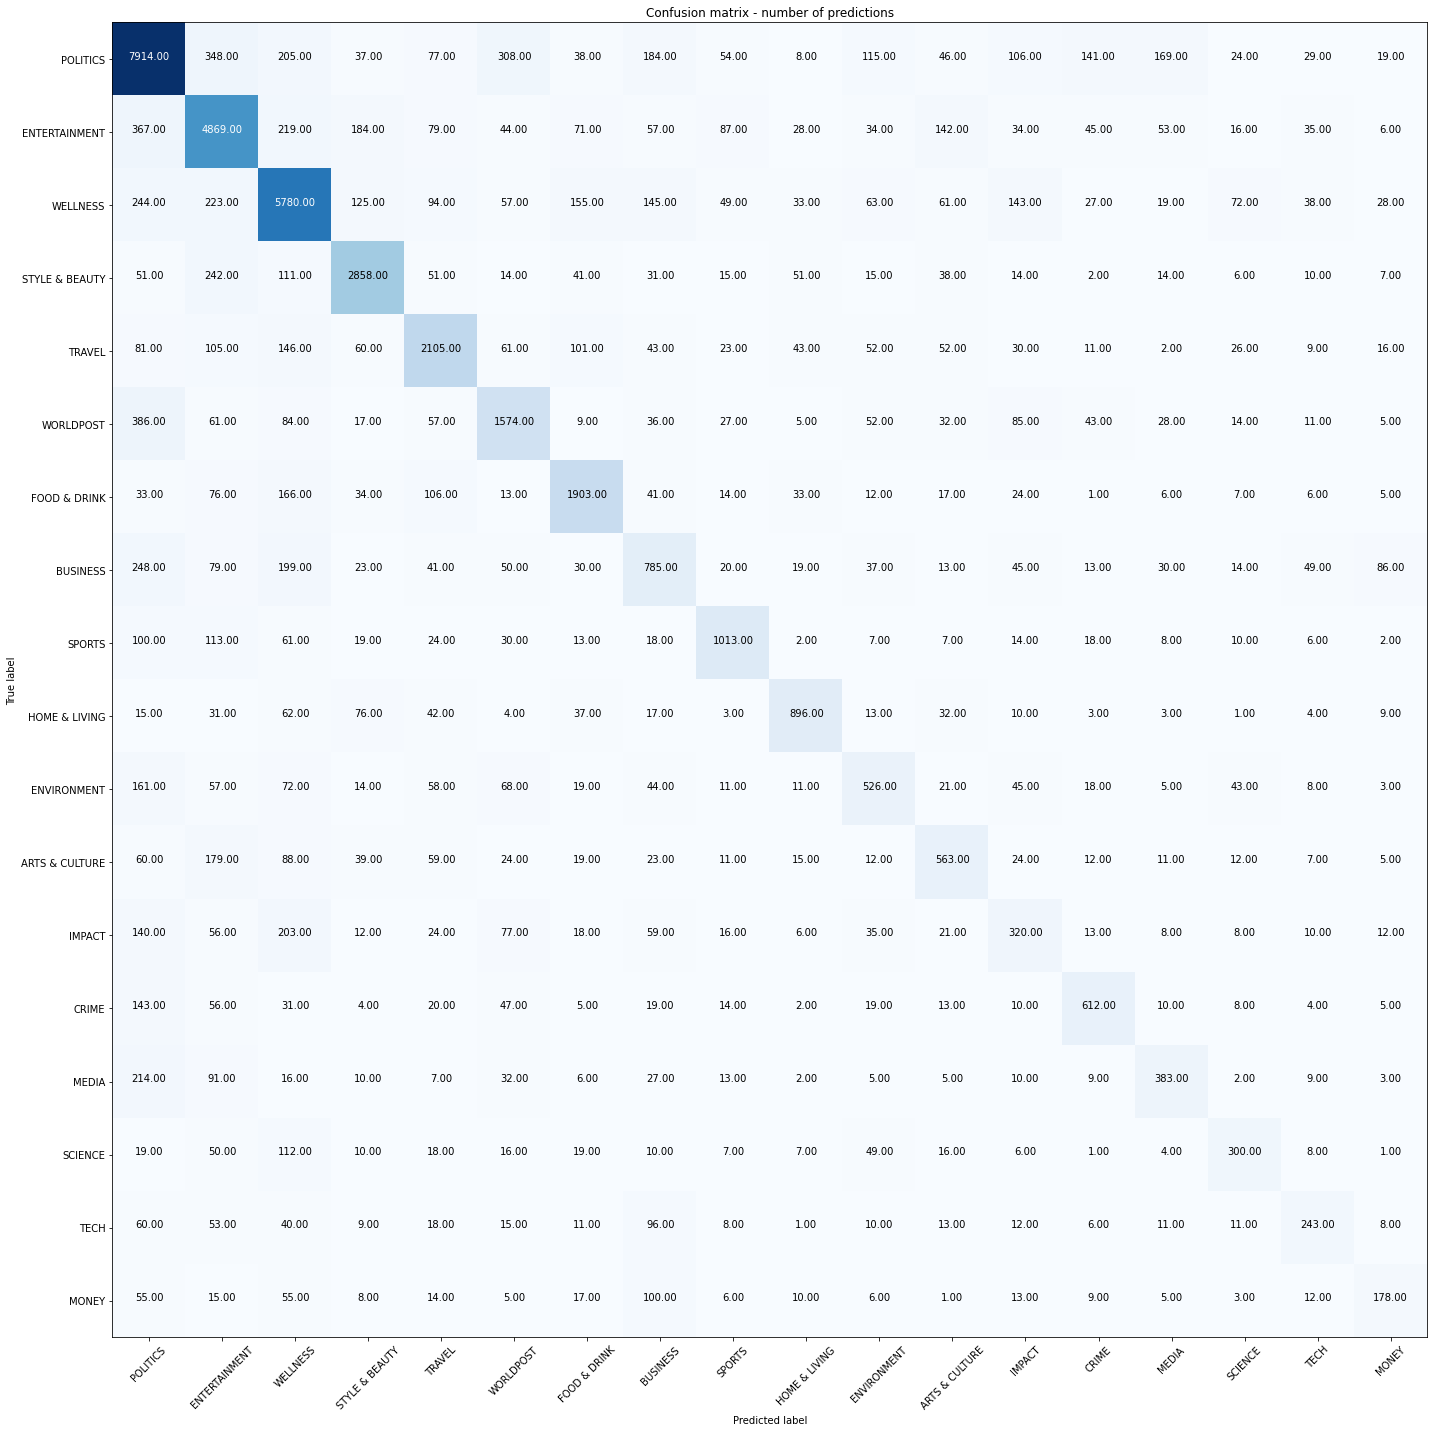

In [94]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF Stemmed data

In [95]:
svm.fit(X_train_tfidf_stem,y_train)

LinearSVC()

In [96]:
y_pred_train=svm.predict(X_train_tfidf_stem)
y_pred_test=svm.predict(X_test_tfidf_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))

svm_tfidf_stem_train_acc = accuracy_score(y_train, y_pred_train)
svm_tfidf_stem_test_acc = accuracy_score(y_test, y_pred_test) 
svm_stem_tfidf_test_mislabeled = (y_test != y_pred_test).sum() 

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9651469358883673
ACC test set: 0.7494266177952115
Mislabeled no: 11690
                precision    recall  f1-score   support

ARTS & CULTURE       0.65      0.52      0.58      1163
      BUSINESS       0.56      0.46      0.51      1781
         CRIME       0.68      0.64      0.66      1022
 ENTERTAINMENT       0.77      0.80      0.78      6370
   ENVIRONMENT       0.57      0.51      0.54      1184
  FOOD & DRINK       0.78      0.80      0.79      2497
 HOME & LIVING       0.79      0.75      0.77      1258
        IMPACT       0.47      0.31      0.37      1038
         MEDIA       0.63      0.42      0.51       844
         MONEY       0.58      0.41      0.48       512
      POLITICS       0.79      0.86      0.82      9822
       SCIENCE       0.68      0.47      0.56       653
        SPORTS       0.78      0.75      0.76      1465
STYLE & BEAUTY       0.84      0.83      0.83      3571
          TECH       0.58      0.43      0.49       625
        TRAVEL 

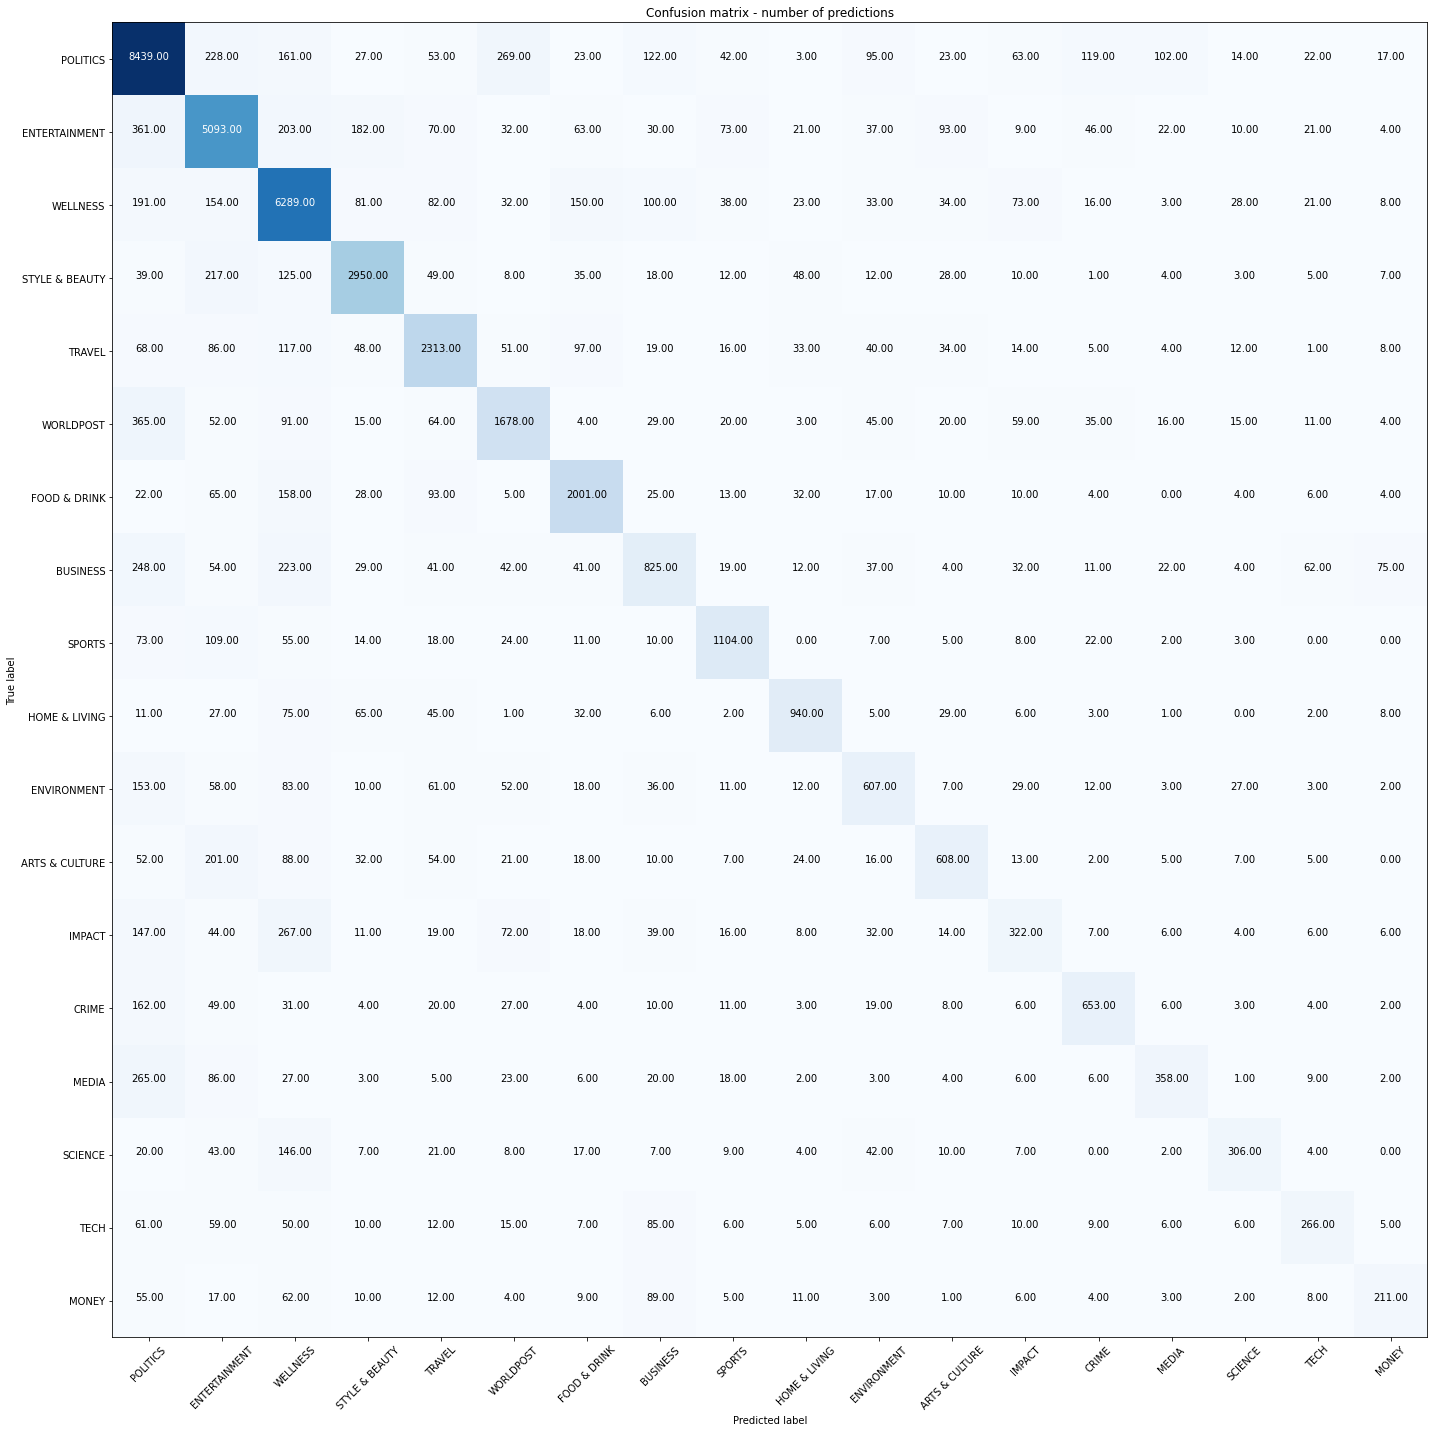

In [97]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF Lemmatized data

In [98]:
svm.fit(X_train_tfidf_lemma,y_train)

LinearSVC()

In [99]:
y_pred_train=svm.predict(X_train_tfidf_lemma)
y_pred_test=svm.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Mislabeled no: {}'.format((y_test != y_pred_test).sum()))


svm_tfidf_lemma_train_acc = accuracy_score(y_train, y_pred_train)
svm_tfidf_lemma_test_acc = accuracy_score(y_test, y_pred_test)
svm_lemma_tfidf_test_mislabeled = (y_test != y_pred_test).sum()

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9670852586420717
ACC test set: 0.7502840117462971
Mislabeled no: 11650
                precision    recall  f1-score   support

ARTS & CULTURE       0.65      0.52      0.58      1163
      BUSINESS       0.56      0.47      0.51      1781
         CRIME       0.69      0.64      0.66      1022
 ENTERTAINMENT       0.76      0.80      0.78      6370
   ENVIRONMENT       0.57      0.49      0.53      1184
  FOOD & DRINK       0.79      0.80      0.80      2497
 HOME & LIVING       0.80      0.74      0.77      1258
        IMPACT       0.48      0.32      0.38      1038
         MEDIA       0.62      0.45      0.52       844
         MONEY       0.57      0.40      0.47       512
      POLITICS       0.78      0.86      0.82      9822
       SCIENCE       0.68      0.47      0.56       653
        SPORTS       0.79      0.76      0.77      1465
STYLE & BEAUTY       0.84      0.83      0.83      3571
          TECH       0.58      0.42      0.49       625
        TRAVEL 

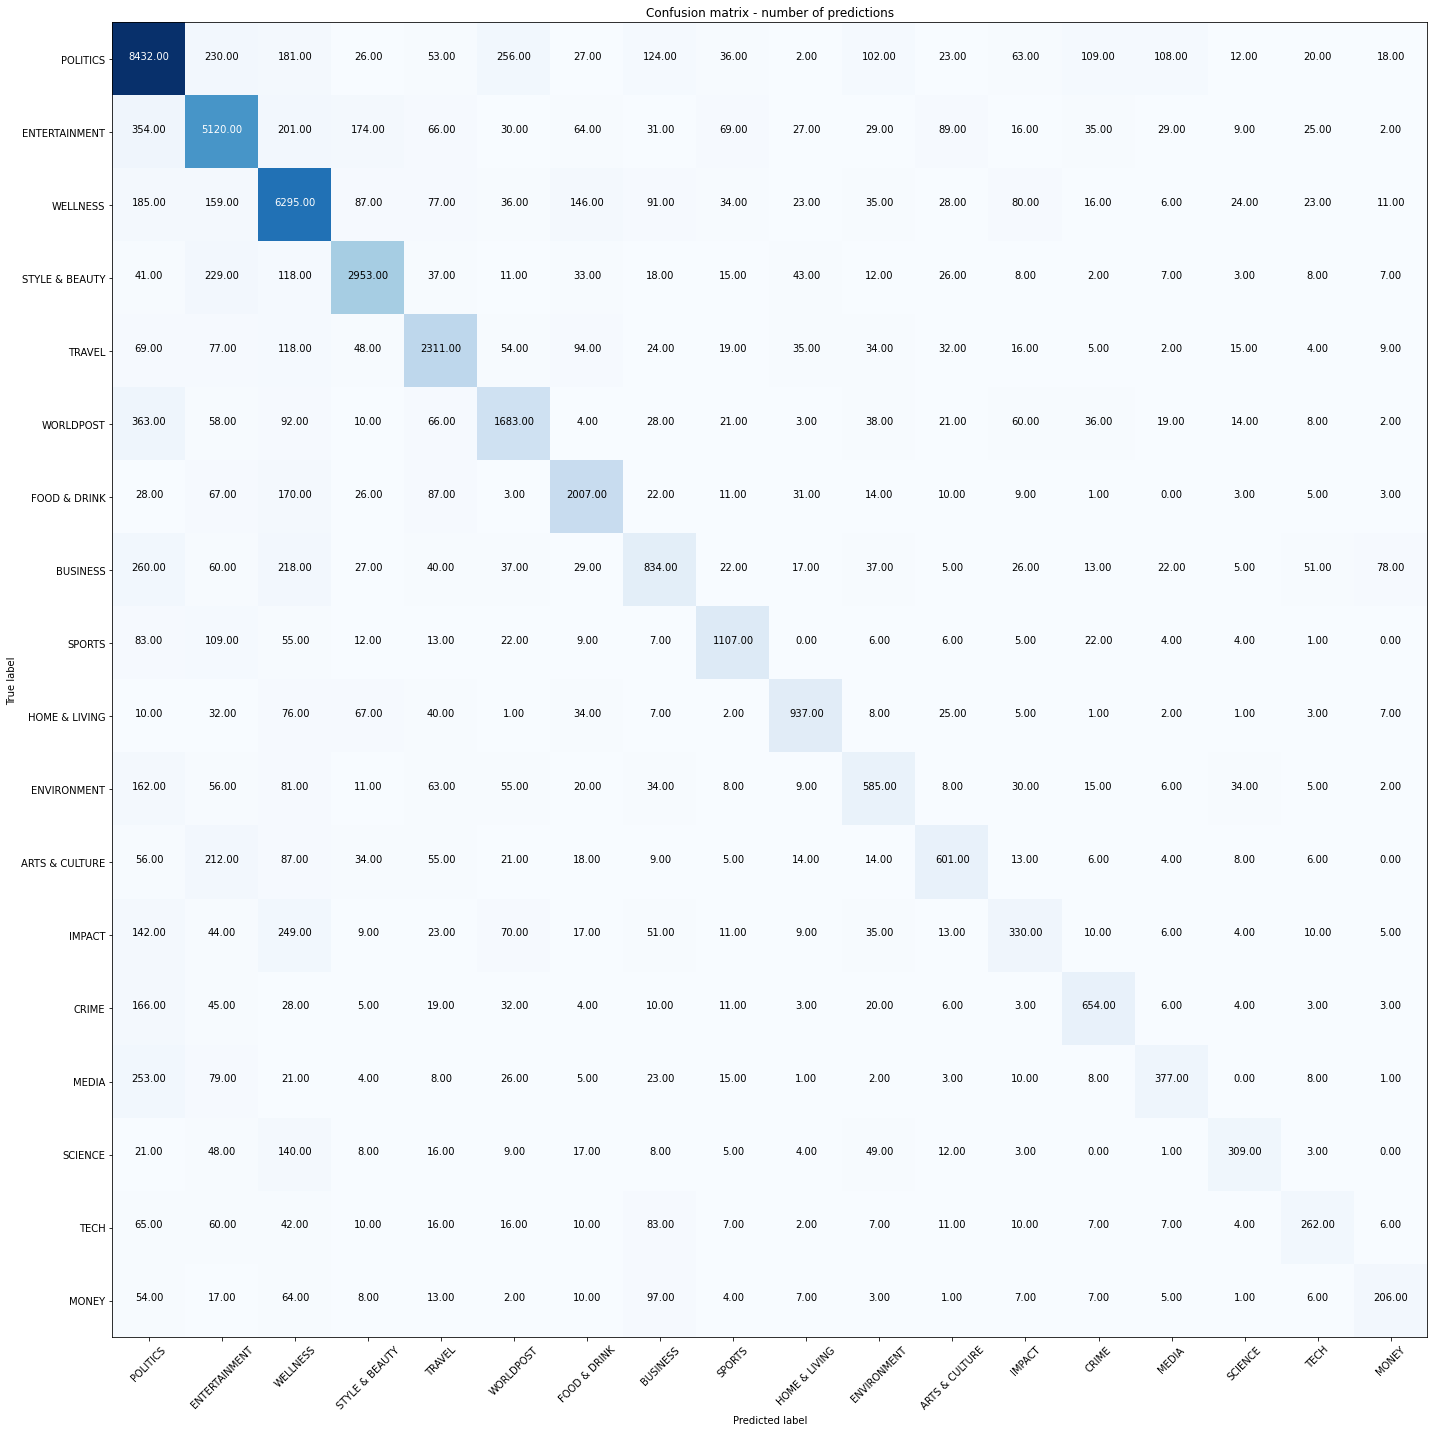

In [100]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Results



In [101]:
print('MultinomialNB BOW ngram (1,2) accuracy stemm data')
print(f'dla train {nb_bow_stem_train_acc}')
print(f'dla test  {nb_bow_stem_test_acc}')
print(f'Mislabeled no: {nb_bow_stem_test_mislabeled}')
print('-'*50)

print('MultinomialNB BOW ngram (1,2) accuracy lemmatized data')
print(f'dla train {nb_bow_lemma_train_acc}')
print(f'dla test  {nb_bow_lemma_test_acc}')
print(f'Mislabeled no: {nb_bow_lemma_test_mislabeled}')
print('-'*50)

print('MultinomialNB Tfidf ngram (1,2) accuracy on stemmed data')
print(f'dla train {nb_tfidf_stem_train_acc}')
print(f'dla test  {nb_tfidf_stem_test_acc}')
print(f'Mislabeled no: {nb_tfidf_stem_test_mislabeled}')
print('-'*50)

print('MultinomialNB Tfidf ngram (1,2)accuracy on lemmatized data')
print(f'dla train {nb_tfidf_lemma_train_acc}')
print(f'dla test  {nb_tfidf_lemma_test_acc}')
print(f'Mislabeled no: {nb_tfidf_lemma_test_mislabeled}')
print('-'*50)

print('Logistic Regression BOW ngram(1,2) accuracy on stemmed data')
print(f'dla train {log_reg_bow_stemm_acc_train}')
print(f'dla test  {log_reg_bow_stemm_acc_test}')
print(f'Mislabeled no: {log_reg_bow_stem_test_mislabeled}')
print('-'*50)

print('Logistic Regression BOW ngram(1,2) accuracy on lemmatized data')
print(f'dla train {log_reg_bow_lemma_acc_train}')
print(f'dla test  {log_reg_bow_lemma_acc_test}')
print(f'Mislabeled no: {log_reg_bow_lemma_test_mislabeled}')
print('-'*50)

print('Logistic Regression TFIDF ngram(1,2) accuracy on stemmed data')
print(f'dla train {log_reg_tfidf_stemm_acc_train}')
print(f'dla test  {log_reg_tfidf_stemm_acc_test}')
print(f'Mislabeled no: {log_reg_tfidf_stem_test_mislabeled}')
print('-'*50)

print('Logistic Regression TFIDF ngram(1,2) accuracy on lemmatized data')
print(f'dla train {log_reg_tfidf_lemma_acc_train}')
print(f'dla test  {log_reg_tfidf_lemma_acc_test}')
print(f'Mislabeled no: {log_reg_tfidf_lemma_test_mislabeled}')
print('-'*50)

print('Random Forest Classifier BOW ngram(1,2) accuracy on stemmed data')
print(f'dla train {rfc_bow_stem_acc_train}')
print(f'dla test  {rfc_bow_stem_acc_test}')
print(f'Mislabeled no: {rfc_bow_stem_test_mislabeled}')
print('-'*50)

print('Random Forest Classifier BOW ngram(1,2) accuracy on lemmatized data')
print(f'dla train {rfc_bow_lemma_acc_train}')
print(f'dla test  {rfc_bow_lemma_acc_test}')
print(f'Mislabeled no: {rfc_bow_lemma_test_mislabeled}')
print('-'*50)


print('Random Forest Classifier TFIDF ngram(1,2) accuracy on stemmed data')
print(f'dla train {rfc_tfidf_stem_acc_train}')
print(f'dla test  {rfc_tfidf_stem_acc_test}')
print(f'Mislabeled no: {rfc_tfidf_stem_test_mislabeled}')
print('-'*50)

print('Random Forest Classifier TFIDF ngram(1,2) accuracy on lemmatized data')
print(f'dla train {rfc_tfidf_lemma_acc_train}')
print(f'dla test  {rfc_tfidf_lemma_acc_test}')
print(f'Mislabeled no: {rfc_tfidf_lemma_test_mislabeled}')
print('-'*50)

rfc_tfidf_stem_acc_train
print('SGDClassifier BOW ngram(1,2) accuracy on stemmed data')
print(f'dla train {sgdc_bow_stem_train_acc}')
print(f'dla test  {sgdc_bow_stem_test_acc}')
print(f'Mislabeled no: {sgdc_bow_stem_test_mislabeled}')
print('-'*50)

print('SGDClassifier BOW ngram(1,2) accuracy on lemmatized data')
print(f'dla train {sgdc_bow_lemma_train_acc}')
print(f'dla test  {sgdc_bow_lemma_test_acc}')
print(f'Mislabeled no: {sgdc_bow_lemma_test_mislabeled}')
print('-'*50)

print('SGDClassifier TFIDF ngram(1,2) accuracy on stemmed data')
print(f'dla train {sgdc_tfidf_stem_train_acc}')
print(f'dla test  {sgdc_tfidf_stem_test_acc}')
print(f'Mislabeled no: {sgdc_tfidf_stem_test_mislabeled}')
print('-'*50)

print('SGDClassifier TFIDF ngram(1,2) accuracy on lemmatized data')
print(f'dla train {sgdc_tfidf_lemma_train_acc}')
print(f'dla test  {sgdc_tfidf_lemma_test_acc}')
print(f'Mislabeled no: {sgdc_tfidf_lemma_test_mislabeled}')
print('-'*50)

print('SVM BOW ngram(1,2) accuracy on stemmed data')
print(f'dla train {svm_stem_train_acc}')
print(f'dla test  {svm_stem_test_acc}')
print(f'Mislabeled no: {svm_stem_bow_test_mislabeled}')
print('-'*50)

print('SVM BOW ngram(1,2) accuracy on lemmatized data')
print(f'dla train {svm_lemma_train_acc}')
print(f'dla test  {svm_lemma_test_acc}')
print(f'Mislabeled no: {svm_lemma_bow_test_mislabeled}')
print('-'*50)

print('SVM TFIDF ngram(1,2) accuracy on stemmed data')
print(f'dla train {svm_tfidf_stem_train_acc}')
print(f'dla test  {svm_tfidf_stem_test_acc}')
print(f'Mislabeled no: {svm_stem_tfidf_test_mislabeled}')
print('-'*50)

print('SVM TFIDF ngram(1,2) accuracy on lemmatized data')
print(f'dla train {svm_tfidf_lemma_train_acc}')
print(f'dla test  {svm_tfidf_lemma_test_acc}')
print(f'Mislabeled no: {svm_lemma_tfidf_test_mislabeled}')
print('-'*50)

MultinomialNB BOW ngram (1,2) accuracy stemm data
dla train 0.8098147110429279
dla test  0.7310355175444238
Mislabeled no: 12548
--------------------------------------------------
MultinomialNB BOW ngram (1,2) accuracy lemmatized data
dla train 0.8155470020301864
dla test  0.7351938782071893
Mislabeled no: 12354
--------------------------------------------------
MultinomialNB Tfidf ngram (1,2) accuracy on stemmed data
dla train 0.6706137409629146
dla test  0.6266049343021884
Mislabeled no: 17420
--------------------------------------------------
MultinomialNB Tfidf ngram (1,2)accuracy on lemmatized data
dla train 0.678174118338738
dla test  0.6327567359012282
Mislabeled no: 17133
--------------------------------------------------
Logistic Regression BOW ngram(1,2) accuracy on stemmed data
dla train 0.9732584950898886
dla test  0.7351081388120807
Mislabeled no: 12358
--------------------------------------------------
Logistic Regression BOW ngram(1,2) accuracy on lemmatized data
dla tra

# GridSearch

In [ ]:
# z powyższych danych wynika, że najlepsze rezultaty zostały osiągniete dla danych po procesie lemmatyzacji:
# Logistic Regression TFIDF ngram(1,2) lemmatized data
# SGDClassifier BOW ngram(1,2) lemmatized data
# SVM TFIDF ngram(1,2) lemmatized data

#przystepuje do optymalizacji parametrów

In [108]:
print('GridSearch Logistic Regression TFIDF ngram(1,2) accuracy on lemmatized data' )

vectorizer = TfidfVectorizer(min_df=5, max_df=0.3, ngram_range=(1,2))

X_train = vectorizer.fit_transform(train_data['lemma'])
X_test = vectorizer.transform(test_data['lemma'])

y_train = train_data.category
y_test= test_data.category

GridSearch Logistic Regression TFIDF ngram(1,2) accuracy on lemmatized data


In [109]:
model = LogisticRegression()

params={
    'C':[0.01,0.1,1,10,100],
    'multi_class':['multinomial'],
    'solver':['saga','sag']
}

In [110]:
grid_search_lr = GridSearchCV(model, param_grid=params, cv=5)

In [111]:
grid_search_lr.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'multi_class': ['multinomial'],
                         'solver': ['saga', 'sag']})

In [112]:
y_pred_lr=grid_search_lr.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lr))


                precision    recall  f1-score   support

ARTS & CULTURE       0.65      0.50      0.57      1163
      BUSINESS       0.54      0.48      0.51      1781
         CRIME       0.72      0.61      0.66      1022
 ENTERTAINMENT       0.74      0.81      0.77      6370
   ENVIRONMENT       0.58      0.50      0.54      1184
  FOOD & DRINK       0.80      0.79      0.79      2497
 HOME & LIVING       0.82      0.74      0.77      1258
        IMPACT       0.47      0.34      0.40      1038
         MEDIA       0.62      0.43      0.51       844
         MONEY       0.59      0.41      0.48       512
      POLITICS       0.77      0.85      0.81      9822
       SCIENCE       0.72      0.47      0.57       653
        SPORTS       0.81      0.72      0.76      1465
STYLE & BEAUTY       0.85      0.82      0.84      3571
          TECH       0.59      0.39      0.47       625
        TRAVEL       0.78      0.78      0.78      2966
      WELLNESS       0.76      0.85      0.80  

In [113]:
print('grid search best params', grid_search_lr.best_params_)
print('accuracy', grid_search_lr.best_score_)                             

grid search best params {'C': 10, 'multi_class': 'multinomial', 'solver': 'saga'}
accuracy 0.7432870767875386


In [104]:
print('GridSearch LinearSVC TFIDF on lemmatized data' )

vectorizer = TfidfVectorizer(min_df=5, max_df=0.3, ngram_range=(1,2))

X_train = vectorizer.fit_transform(train_data['lemma'])
X_test = vectorizer.transform(test_data['lemma'])

y_train = train_data.category
y_test= test_data.category


svm_model=LinearSVC()

params = {
    "loss" : ["hinge","squared_hinge"],
    "C" : [ 0.001, 0.01, 0.1, 1, 10],
    'multi_class': ['ovr','crammer_singer'],
    'class_weight': ['balanced']
}

grid_search_svm = GridSearchCV(svm_model, param_grid=params, cv=5)



GridSearch LinearSVC TFIDF on lemmatized data


In [105]:
grid_search_svm.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': ['balanced'],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr', 'crammer_singer']})

In [106]:
y_pred_svm=grid_search_svm.predict(X_test)


print(classification_report(y_test, y_pred_svm))

                precision    recall  f1-score   support

ARTS & CULTURE       0.55      0.58      0.56      1163
      BUSINESS       0.50      0.50      0.50      1781
         CRIME       0.61      0.73      0.66      1022
 ENTERTAINMENT       0.81      0.76      0.79      6370
   ENVIRONMENT       0.50      0.56      0.53      1184
  FOOD & DRINK       0.76      0.83      0.79      2497
 HOME & LIVING       0.75      0.78      0.77      1258
        IMPACT       0.37      0.42      0.39      1038
         MEDIA       0.51      0.57      0.54       844
         MONEY       0.45      0.50      0.47       512
      POLITICS       0.85      0.79      0.82      9822
       SCIENCE       0.53      0.55      0.54       653
        SPORTS       0.73      0.80      0.77      1465
STYLE & BEAUTY       0.84      0.83      0.84      3571
          TECH       0.48      0.52      0.50       625
        TRAVEL       0.77      0.77      0.77      2966
      WELLNESS       0.82      0.81      0.81  

In [107]:
print('grid search best params', grid_search_svm.best_params_)
print('accuracy', grid_search_svm.best_score_)

grid search best params {'C': 1, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'multi_class': 'ovr'}
accuracy 0.7409537456229898


In [125]:
from sklearn import metrics 

models = []

models.append(('Logistic regression', grid_search_lr))
models.append(('LinearSVC', grid_search_svm))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
mislabeled= []

for name, model in models:
  print(name)
  print("precision_score: {}".format(metrics.precision_score(y_test, model.predict(X_test), average= 'weighted') ))
  print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test), average= 'weighted') ))
  print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test), average= 'weighted') ))
  print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test))))
  print('Mislabeled no: {}'.format((y_test != model.predict(X_test)).sum()))
  precision_score.append(metrics.precision_score(y_test, model.predict(X_test) , average= 'weighted'))
  recall_score.append(metrics.recall_score(y_test, model.predict(X_test), average= 'weighted'))
  f1_score.append( metrics.f1_score(y_test, model.predict(X_test), average= 'weighted'))
  accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
  mislabeled.append((y_test != model.predict(X_test)).sum())  



Logistic regression
precision_score: 0.7404894466033674
recall_score: 0.7463828692688573
f1_score: 0.7404107167507787
accuracy_score: 0.7463828692688573
Mislabeled no: 11832
LinearSVC
precision_score: 0.7490351664653799
recall_score: 0.7423745525475318
f1_score: 0.7449480178532295
accuracy_score: 0.7423745525475318
Mislabeled no: 12019


In [126]:
results = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'mislabeled': mislabeled
    }
df = pd.DataFrame(results)
df 

precision_score  recall_score  f1_score  accuracy_score  mislabeled
0         0.740489      0.746383  0.740411        0.746383       11832
1         0.749035      0.742375  0.744948        0.742375       12019

In [127]:
df = df.set_axis(['Logistic Regression', 'LinearSVC'])

In [128]:
df

precision_score  recall_score  ...  accuracy_score  mislabeled
Logistic Regression         0.740489      0.746383  ...        0.746383       11832
LinearSVC                   0.749035      0.742375  ...        0.742375       12019

[2 rows x 5 columns]